# Institution Publication statistics
In this notebook, we will use the data retrieved from OpenAlex to analyze the trends in publications of MGHIHP

To find an institution ID, please type in your browser https://api.openalex.org/institutions?search=mgh%20Institute%20of%20health%20professions (replace the last bit with your desired institution name). Please find one that looks correct in the results and copy/paste its "id" field below.


Similarly, to find a specific author, please enter in your browser this url https://api.openalex.org/authors?search=jordan%20green (replace the name at the end by whatever you need) and copy/paste the id.

In [1]:
# adjust these parameters as needed
home_institution = "https://openalex.org/I158133745"
home_institution_id = home_institution.split('/')[-1]

# time span to consider publications for
begin = 2010
end = 2023

# for plotting rankings
top_n_topics = 20
top_n_rankings = 20

# Where is your institution located?
home_country_code = 'US'

# to save individual plots as high-definition images
# make sure the folder exists!
folder_plots = f"plots_{home_institution_id}/"

# to save a powerpoint presentation with the plots
ppt_filename = f"{home_institution_id}_statistics.ppt"

In [2]:
import os

def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder created: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

# Example usage
ensure_folder_exists(folder_plots)

Folder created: plots_I158133745/


### Data loading

In [3]:
pip install python-pptx

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pyalex

Note: you may need to restart the kernel to use updated packages.


In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import pprint
import itertools
import networkx as nx
import csv
import requests
from tqdm import tqdm
import os

from pptx import Presentation
from pptx.util import Inches
import io
from pathlib import Path

from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders

In [6]:
sample = Works().filter(authorships={"institutions": {"id": home_institution}}).sort(publication_year="desc").get()
pprint.pprint(sample)

[{'abstract_inverted_index': {'(NP)': [12],
                              'Doctorate': [0],
                              'Nursing': [2],
                              'Practice': [3],
                              'and': [20],
                              'are': [16],
                              'but': [14],
                              'comparative': [18],
                              'conflate': [23],
                              'designs': [22],
                              'educational': [24],
                              'entry': [8],
                              'few': [17],
                              'for': [7],
                              'is': [5],
                              'nurse': [10],
                              'of': [1],
                              'pathways.': [25],
                              'practice': [13],
                              'practitioner': [11],
                              'preparation': [4],
                              'rec

In [7]:
pager = Works().filter(authorships={"institutions": {"id": home_institution}}).sort(publication_year="desc").paginate(per_page=200)
pages = []
for page in pager:
    print(len(page), "additional entries collected...")
    pages = pages + page
print(len(pages), "total entries")
data = pages

200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
106 additional entries collected...
0 additional entries collected...
3106 total entries


Saving a local copy of the database

In [8]:
# The filename where you want to save the JSON data
filename = f'{folder_plots}' + home_institution.split('/')[-1] + '.json'

# Saving the list of dictionaries as a JSON file
with open(filename, 'w') as file:
    json.dump(pages, file, indent=4)

print(f'Data saved to {filename}')

Data saved to plots_I158133745/I158133745.json


save a .csv version with just some core information

In [9]:
# Specify the CSV file where you want to save the information
csv_file_path = f'{folder_plots}/output_data.csv'  # Update this to your desired CSV file path

# Define the CSV headers
headers = ['ID', 'Title', 'Publication Year', 'Authors', 'Cited By Count', 'Author Affiliations']

# Write data to the CSV file
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    for publication in data:
        # Extract relevant information from each publication
        pub_id = publication.get('id')
        title = publication.get('title')
        pub_year = publication.get('publication_year')
        cited_by_count = publication.get('cited_by_count', 0)
        
        # Concatenate author names
        authors = ', '.join([authorship.get('author', {}).get('display_name', 'N/A') for authorship in publication.get('authorships', [])])

        # Concatenate all affiliations for all authors
        affiliations = '; '.join([', '.join([inst.get('display_name', 'N/A') for inst in authorship.get('institutions', [])]) for authorship in publication.get('authorships', [])])

        # Write the publication data to the CSV
        writer.writerow({
            'ID': pub_id,
            'Title': title,
            'Publication Year': pub_year,
            'Authors': authors,
            'Cited By Count': cited_by_count,
            'Author Affiliations': affiliations
        })

print(f"Data successfully written to {csv_file_path}")

Data successfully written to plots_I158133745//output_data.csv


plotting code

In [10]:
def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder created: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

def plot_publications_with_dynamic_sizing(publications_data, begin, end, title="Publications", save_plot=False, ppt_filename=None):
    # Filter publications within the specified time window
    filtered_publications = {year: count for year, count in publications_data.items() if begin <= year <= end}
    
    # Sort the dictionary by year
    years = sorted(filtered_publications.keys())
    counts = [filtered_publications[year] for year in years]
    
    # Calculate year-to-year percentage increase
    percentage_increases = [0]  # No increase for the first year
    for i in range(1, len(years)):
        if counts[i-1] == 0:  # Avoid division by zero
            increase = 0
        else:
            increase = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
        percentage_increases.append(increase)
    
    # Determine the size of the plot based on the number of years to display
    width_per_year = 1  # Assumed width per year for readability
    fig_width = max(len(years) * width_per_year, 8)  # Ensure a minimum width for very short ranges
    fig_height = 6  # Fixed height

    fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

    # Plot histogram of publications per year
    bars = ax1.bar(years, counts, color='b', alpha=0.6, label='Publications per Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Publications', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Annotate the bars with the percentage increases
    for bar, increase in zip(bars, percentage_increases):
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{increase:+.1f}%', ha='center', va='bottom')

    # Title and legend
    plt.title(title + ' per Year and Year-to-Year Increase in Percentage')
    fig.tight_layout()

    # Save plot if requested
    if save_plot:
        # Save as image
        file_name = f"{title}_{begin}_{end}.png"
        plt.savefig(file_name, dpi=300)  # Save the plot with high resolution
        print(f"Plot saved as {file_name}")
        
        # Save as a .csv
        publications_data_df = pd.DataFrame(list(publications_data.items()), columns=['Year', f'{title}'])
        publications_data_df.to_csv(os.path.join(folder_plots,f"{title}_{begin}_{end}.csv"), index=False)

        # Save to PowerPoint if ppt_filename is provided
        if ppt_filename:
            ppt_path = Path(ppt_filename)
            # Ensure the folder exists
            ensure_folder_exists(ppt_path.parent)
            
            # Create a presentation object or open an existing one
            prs = Presentation(ppt_path) if ppt_path.exists() else Presentation()

            # Save plot to a bytes buffer
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=300)
            buf.seek(0)

            # Add a slide with the plot
            slide_layout = prs.slide_layouts[5]  # Use the blank slide layout
            slide = prs.slides.add_slide(slide_layout)
            title_placeholder = slide.shapes.title
            title_placeholder.text = title

            # Add the plot image to the slide
            left = Inches(1)
            top = Inches(1.5)
            slide.shapes.add_picture(buf, left, top, width=Inches(8), height=Inches(6))

            # Save the presentation
            prs.save(ppt_path)
            print(f"Plot added to {ppt_path}")

    plt.show()

## First of all, let us compute the volume of publication per year and the percentage increase in publication volume per year

Plot saved as Publications_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


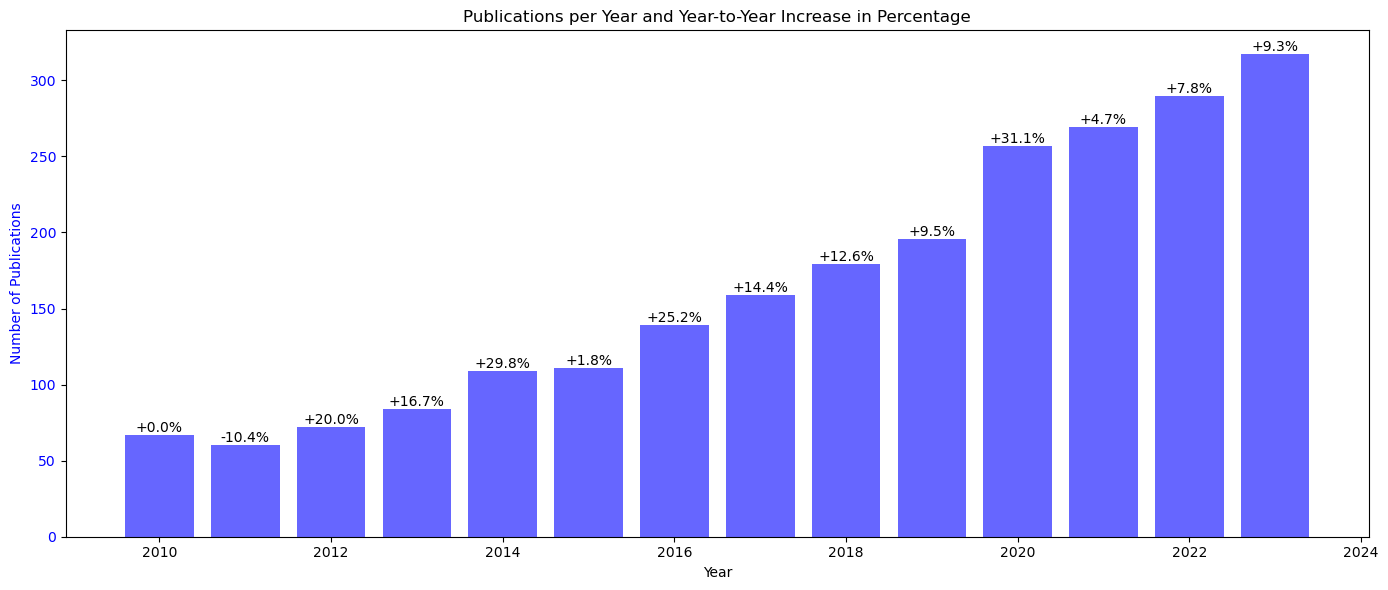

In [11]:
# Count the number of publications per year
publications_per_year = {}
for item in data:
    year = item.get('publication_year')
    if year in publications_per_year:
        publications_per_year[year] += 1
    else:
        publications_per_year[year] = 1

plot_publications_with_dynamic_sizing(publications_per_year, begin, end, save_plot=True, ppt_filename=ppt_filename)

## We now compute the number of collaborations with authors from a different institution per year 

As the sum of authors affiliated with another institution appearing on our publications

Plot saved as Collaborations per authors_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


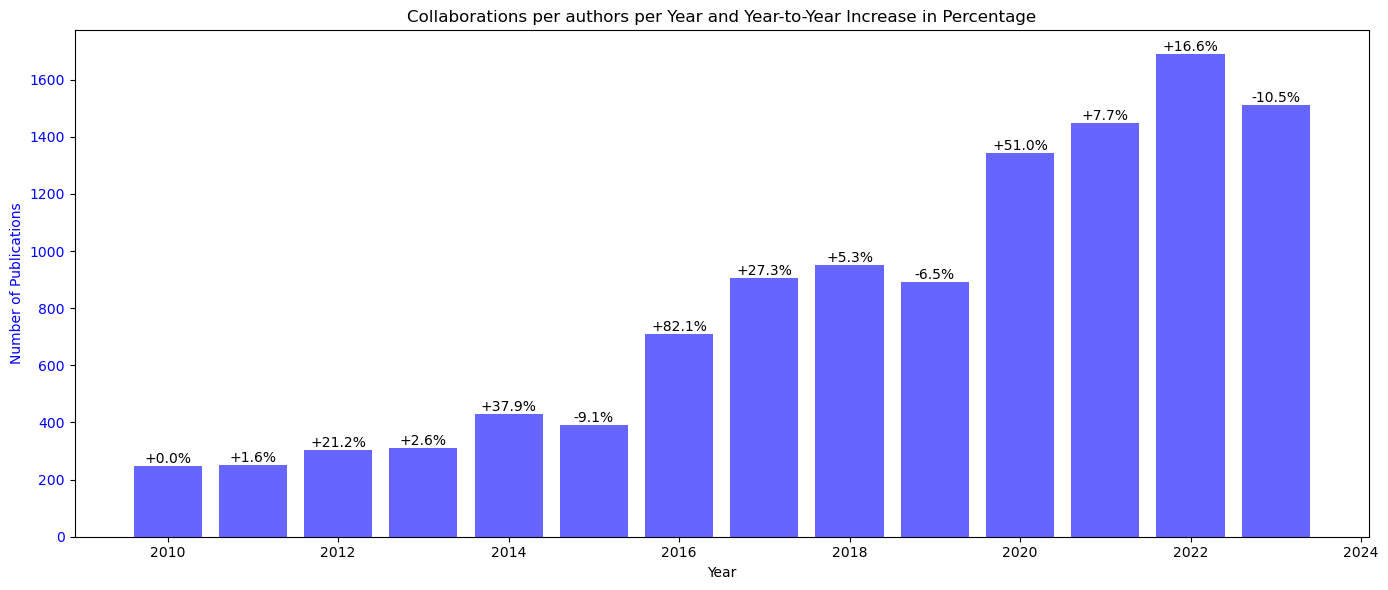

In [12]:
def count_authors_excluding_institution_all_years(data, excluded_institution_id):
    author_counts_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        count = 0
        for authorship in publication.get('authorships', []):
            # Check if author is affiliated with the excluded institution
            affiliated_with_excluded = any(
                excluded_institution_id in institution['id'] for institution in authorship.get('institutions', []))
            if not affiliated_with_excluded:
                count += 1
        
        if year in author_counts_by_year:
            author_counts_by_year[year] += count
        else:
            author_counts_by_year[year] = count

    return author_counts_by_year

# Count authors not affiliated with the specified institution for all publications in the dataset
author_counts_excluding_institution = count_authors_excluding_institution_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(author_counts_excluding_institution, begin, end, "Collaborations per authors", save_plot=True, ppt_filename=ppt_filename)


## Number of different institutions collaborated with per year

Plot saved as Collaborations with Other Institutions_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


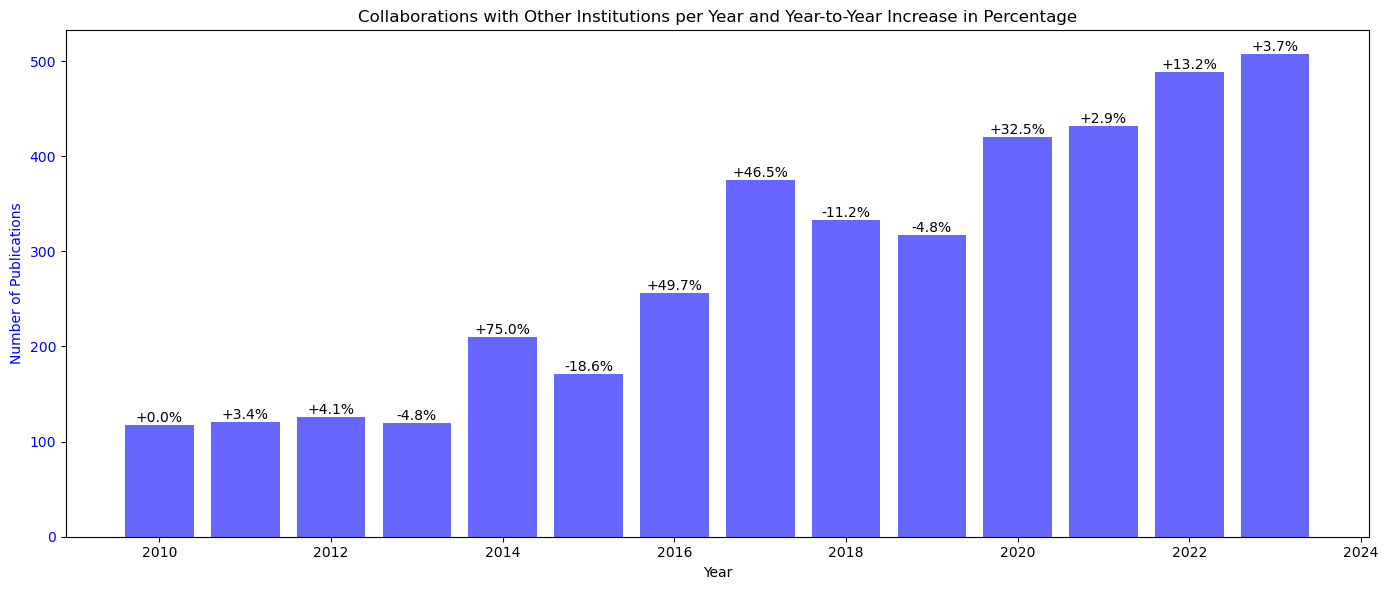

In [13]:
def count_unique_collaborating_institutions_all_years(data, excluded_institution_id):
    unique_institutions_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        unique_institutions = set()

        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                if institution['id'] != excluded_institution_id:
                    unique_institutions.add(institution['id'])

        if year in unique_institutions_by_year:
            unique_institutions_by_year[year].update(unique_institutions)
        else:
            unique_institutions_by_year[year] = unique_institutions

    # Convert sets to counts
    collaborating_institution_counts = {year: len(institutions) for year, institutions in unique_institutions_by_year.items()}

    return collaborating_institution_counts

# Count unique collaborating institutions per year, excluding a specific institution
collaborating_institutions_counts = count_unique_collaborating_institutions_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_institutions_counts, begin, end, "Collaborations with Other Institutions", save_plot=True, ppt_filename=ppt_filename)


## Number of different foreign countries collaborated with per year

Plot saved as Collaborations with Foreign Countries_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


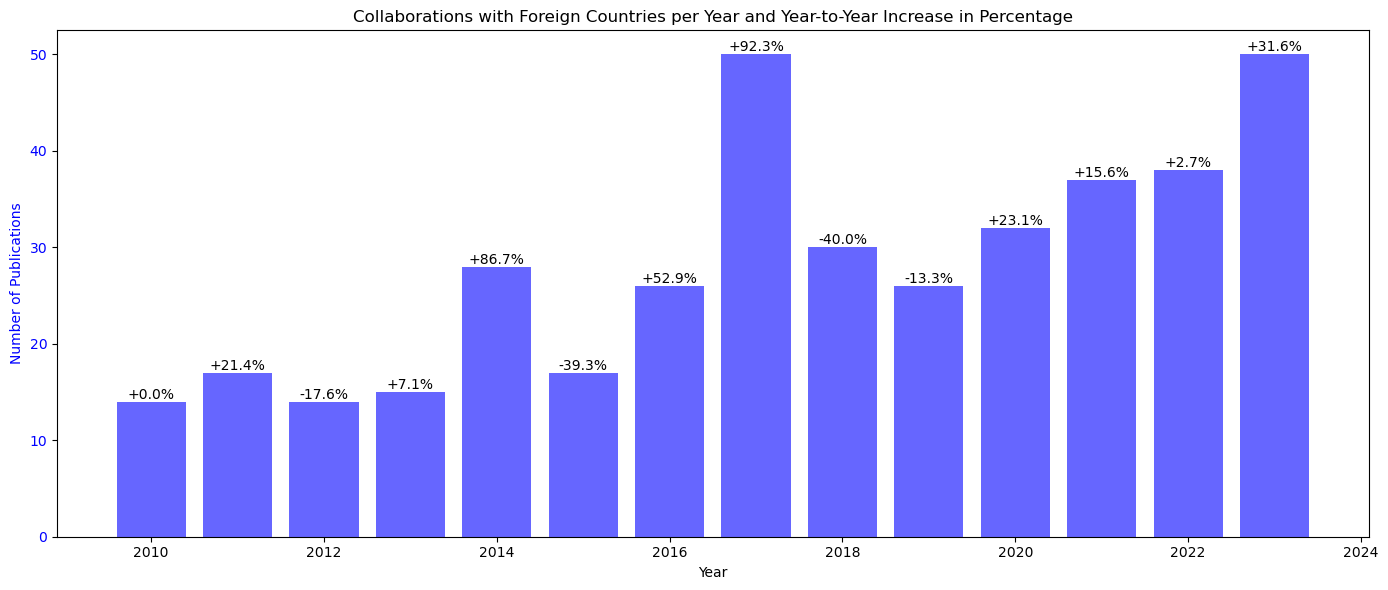

In [14]:
def count_unique_collaborating_countries_all_years(data, excluded_institution_id):
    unique_countries_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        unique_countries = set()

        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                # Only consider institutions other than the excluded one
                if institution['id'] != excluded_institution_id:
                    # Add the country of the institution, if available
                    country_code = institution.get('country_code')
                    if country_code:
                        unique_countries.add(country_code)

        if year in unique_countries_by_year:
            unique_countries_by_year[year].update(unique_countries)
        else:
            unique_countries_by_year[year] = unique_countries

    # Convert sets to counts
    collaborating_country_counts = {year: len(countries) for year, countries in unique_countries_by_year.items()}

    return collaborating_country_counts

# Count unique collaborating countries per year, excluding a specific institution
collaborating_countries_counts = count_unique_collaborating_countries_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_countries_counts, begin, end, "Collaborations with Foreign Countries", save_plot=True, ppt_filename=ppt_filename)


## Number of different publication venues, journals, etc per year

Plot saved as Unique Publication Venue_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


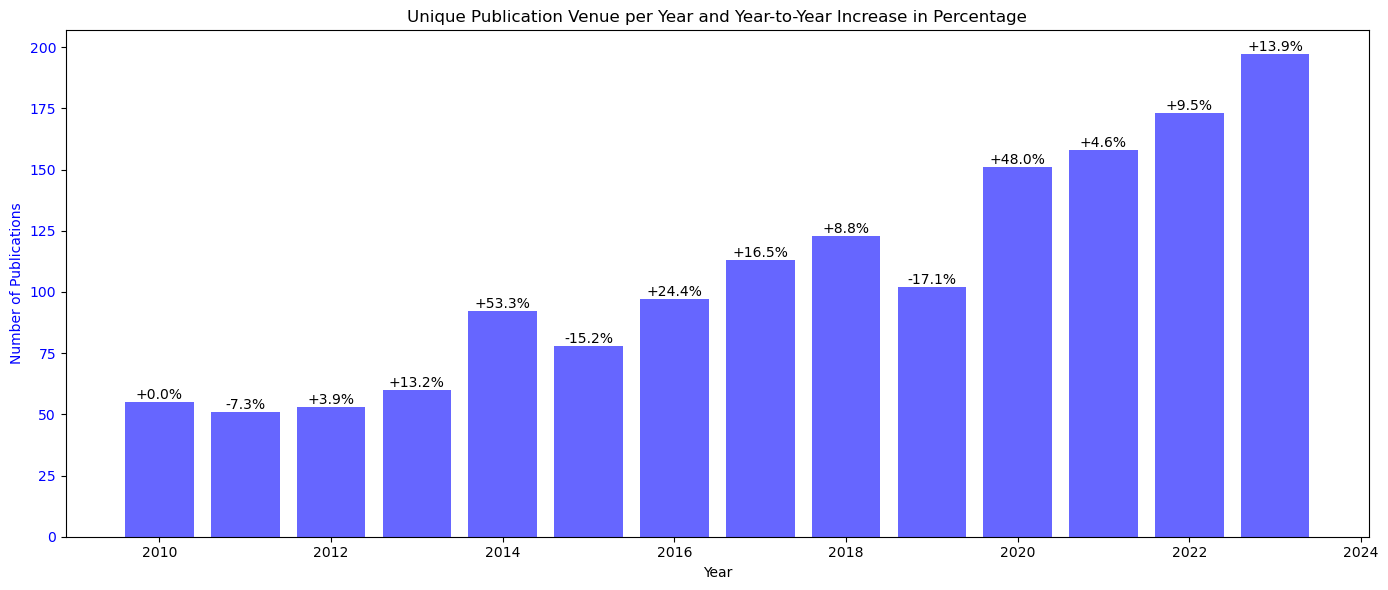

In [15]:
def count_unique_venues_all_years_corrected(data):
    unique_venues_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        # Ensure 'primary_location' is a dictionary and 'source' is not None before accessing 'id'
        primary_location = publication.get('primary_location', {})
        source = primary_location.get('source') if isinstance(primary_location, dict) else None
        venue_id = source.get('id') if source else None

        if venue_id:  # Only consider publications with a known venue
            if year in unique_venues_by_year:
                unique_venues_by_year[year].add(venue_id)
            else:
                unique_venues_by_year[year] = {venue_id}

    # Convert sets to counts
    unique_venue_counts = {year: len(venues) for year, venues in unique_venues_by_year.items()}

    return unique_venue_counts


# Count unique venues per year with the fixed function
unique_venues_counts_fixed = count_unique_venues_all_years_corrected(data)

# Plotting the result with the fixed data
plot_publications_with_dynamic_sizing(unique_venues_counts_fixed, begin, end, "Unique Publication Venue", save_plot=True, ppt_filename=ppt_filename)


## Number of first authorships per year

Plot saved as First Authors_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


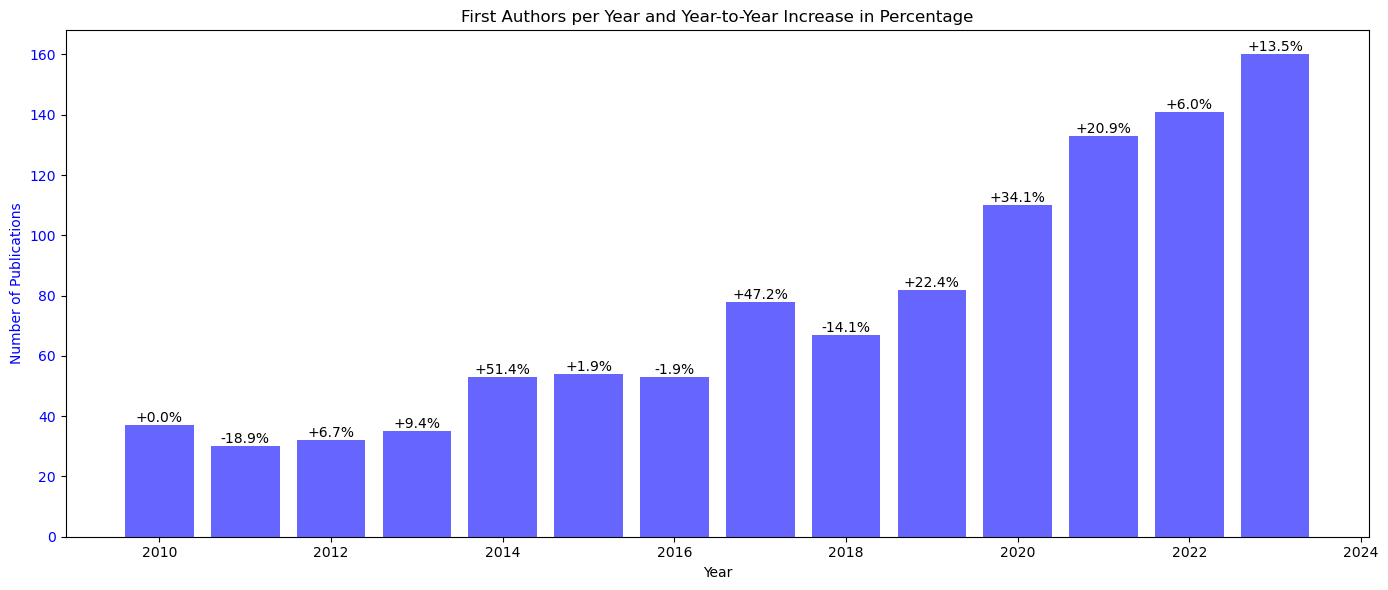

In [16]:
def count_first_author_affiliation_all_years(data, home_institution_id):
    first_author_affiliation_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        for authorship in publication.get('authorships', []):
            if authorship.get('author_position') == 'first':
                # Check if the first author is affiliated with the home institution
                affiliated_with_home = any(
                    home_institution_id == institution['id'] for institution in authorship.get('institutions', []))
                if affiliated_with_home:
                    if year in first_author_affiliation_counts:
                        first_author_affiliation_counts[year] += 1
                    else:
                        first_author_affiliation_counts[year] = 1
                break  # Only consider the first author, so break after checking

    return first_author_affiliation_counts

# Count publications where the first author is affiliated with the home institution per year
first_author_affiliation_counts = count_first_author_affiliation_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(first_author_affiliation_counts, begin, end, "First Authors", save_plot=True, ppt_filename=ppt_filename)


## Number of last authorships per year

Plot saved as Last Authors_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


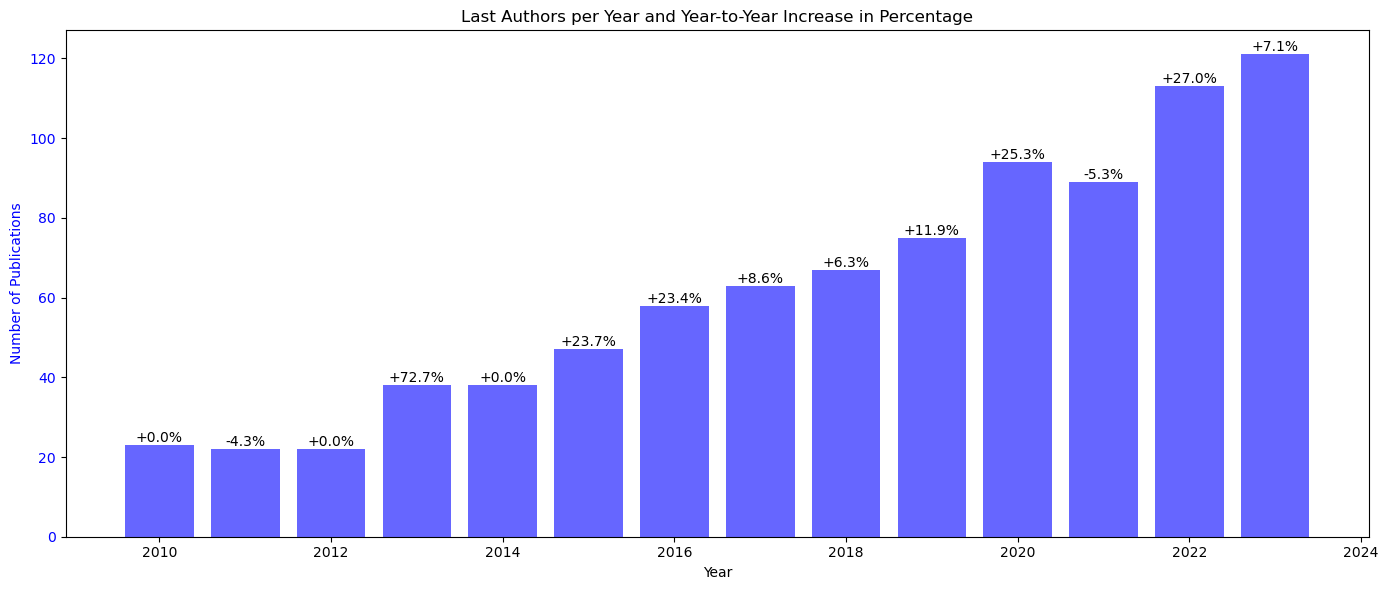

In [17]:
def count_first_author_affiliation_all_years(data, home_institution_id):
    first_author_affiliation_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        for authorship in publication.get('authorships', []):
            if authorship.get('author_position') == 'last':
                # Check if the first author is affiliated with the home institution
                affiliated_with_home = home_institution_id in [institution['id'] for institution in authorship.get('institutions', [])]
                if affiliated_with_home:
                    if year in first_author_affiliation_counts:
                        first_author_affiliation_counts[year] += 1
                    else:
                        first_author_affiliation_counts[year] = 1

    return first_author_affiliation_counts

# Count publications where the first author is affiliated with the home institution per year
last_author_affiliation_counts = count_first_author_affiliation_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(last_author_affiliation_counts, begin, end, "Last Authors", save_plot=True, ppt_filename=ppt_filename)

## Number of citations attributed to the year's papers per year, to date

Plot saved as Publications_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


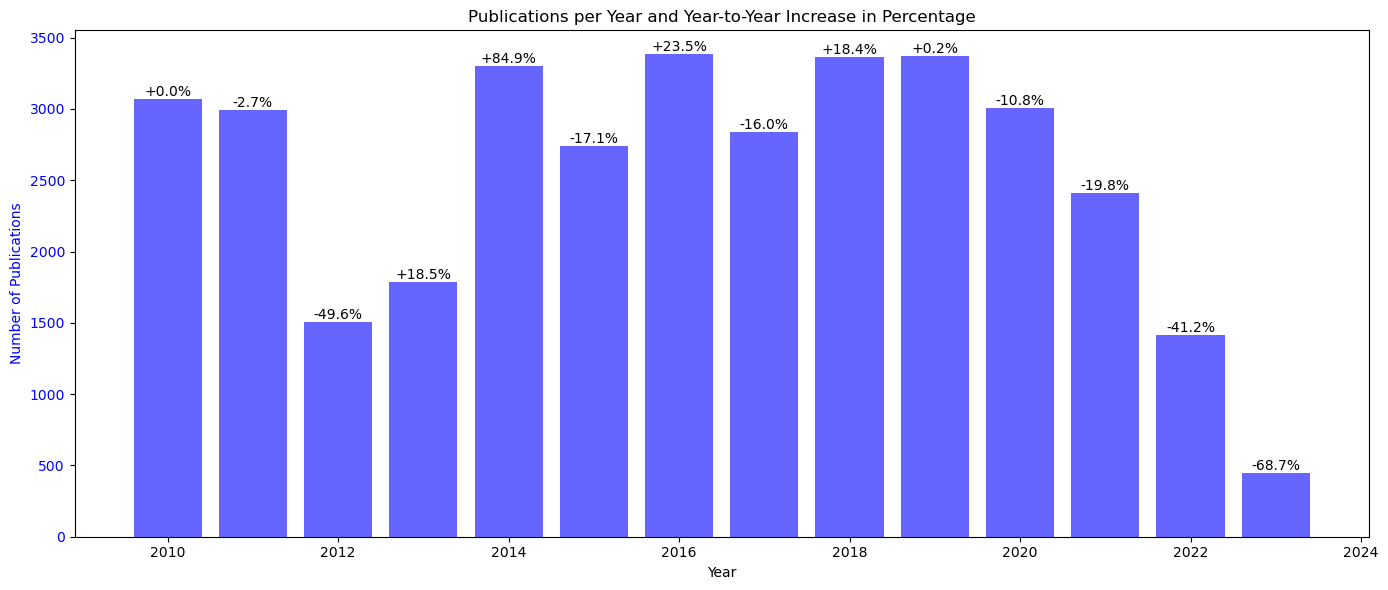

In [18]:
def count_citations_per_year(data):
    citations_per_year = {}

    for publication in data:
        year = publication.get('publication_year')
        citations_count = publication.get('cited_by_count', 0)

        if year in citations_per_year:
            citations_per_year[year] += citations_count
        else:
            citations_per_year[year] = citations_count

    return citations_per_year

# Count the total number of citations accumulated by publications in each year
citations_counts_per_year = count_citations_per_year(data)

# Plotting the result
plot_publications_with_dynamic_sizing(citations_counts_per_year, begin, end, save_plot=True, ppt_filename=ppt_filename)


## Looking at the most popular topics over the selected time period and how oftne they co-occur in papers

Plot saved as Topics of Papers_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


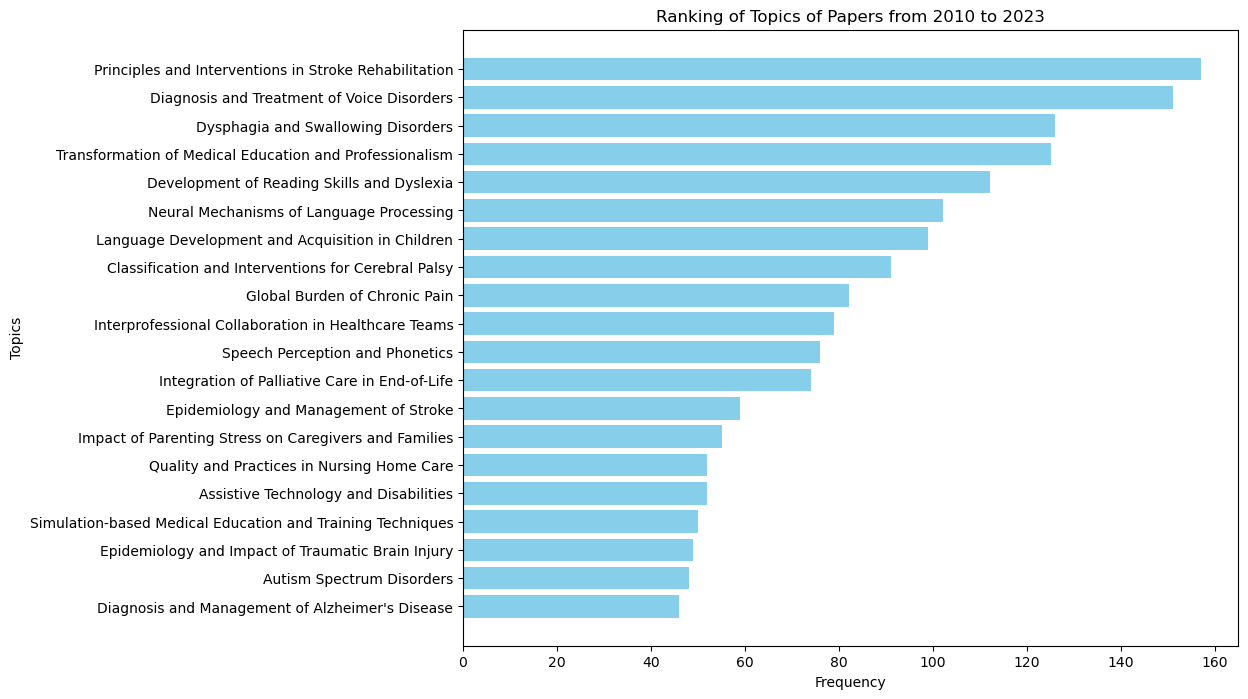

In [19]:
def plot_ranking(topic_counts, begin, end, top_n=10, title="Topics of Papers", save_plot=False, ppt_filename=None):

    # Prepare data for plotting
    topics = list(topic_counts.keys())
    counts = list(topic_counts.values())

    # Sort the topics by count
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_topics = [topics[i] for i in sorted_indices][:top_n]
    sorted_counts = [counts[i] for i in sorted_indices][:top_n]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_topics, sorted_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Topics')
    plt.title(f'Ranking of {title} from {begin} to {end}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    
    # Save the data if needed
    if save_plot:
        # Save as image
        file_name = f"{title}_{begin}_{end}.png"
        plt.savefig(file_name, dpi=300)  # Save the plot with high resolution
        print(f"Plot saved as {file_name}")
        
        # Save as a .csv
        publications_data_df = pd.DataFrame(list(topic_counts.items()), columns=['Year', f'{title}'])
        publications_data_df.to_csv(os.path.join(folder_plots,f"{title}_{begin}_{end}.csv"), index=False)

        # Save to PowerPoint if ppt_filename is provided
        if ppt_filename:
            ppt_path = Path(ppt_filename)
            # Ensure the folder exists
            ensure_folder_exists(ppt_path.parent)
            
            # Create a presentation object or open an existing one
            prs = Presentation(ppt_path) if ppt_path.exists() else Presentation()

            # Save plot to a bytes buffer
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=300)
            buf.seek(0)

            # Add a slide with the plot
            slide_layout = prs.slide_layouts[5]  # Use the blank slide layout
            slide = prs.slides.add_slide(slide_layout)
            title_placeholder = slide.shapes.title
            title_placeholder.text = title

            # Add the plot image to the slide
            left = Inches(1)
            top = Inches(1.5)
            slide.shapes.add_picture(buf, left, top, width=Inches(8), height=Inches(6))

            # Save the presentation
            prs.save(ppt_path)
            print(f"Plot added to {ppt_path}")
    plt.show()

topic_counts = {}

# Iterate through each publication
for publication in data:
    year = publication.get('publication_year')
    # Check if the publication is within the specified time span
    if begin <= year <= end:
        # Iterate through the topics of each publication
        for topic in publication.get('topics', []):
            topic_name = topic.get('display_name')
            # Increment the count for each topic
            if topic_name in topic_counts:
                topic_counts[topic_name] += 1
            else:
                topic_counts[topic_name] = 1


                
plot_ranking(topic_counts, begin, end, top_n=top_n_topics, title="Topics of Papers", save_plot=True, ppt_filename=ppt_filename)


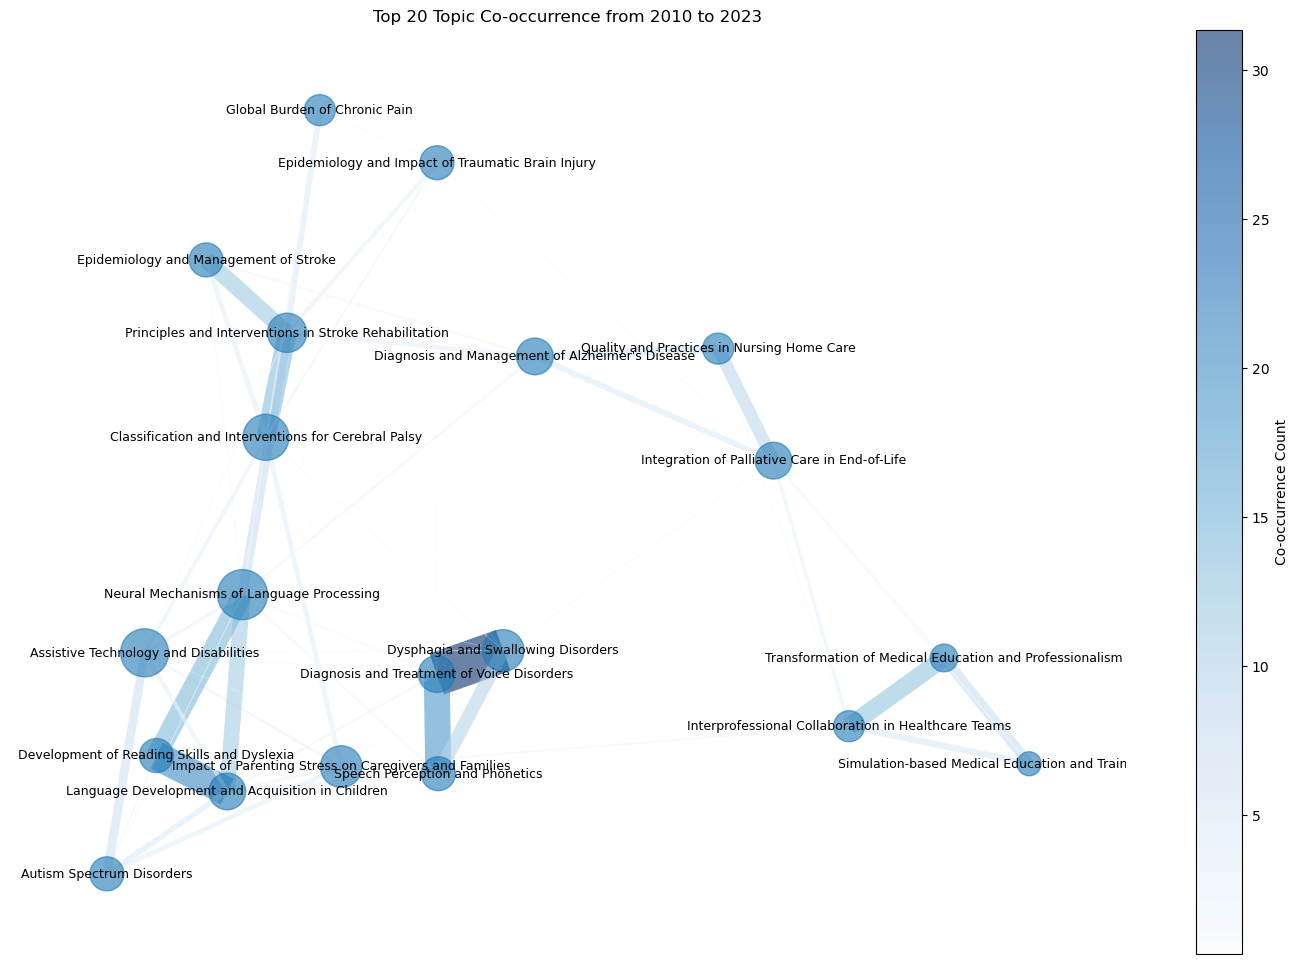

In [20]:
def get_top_topics(data, begin, end, top_n=10):
    topic_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            for topic in publication.get('topics', []):
                topic_name = topic.get('display_name')
                if topic_name in topic_counts:
                    topic_counts[topic_name] += 1
                else:
                    topic_counts[topic_name] = 1

    # Sort topics by frequency and select the top N
    sorted_topics = sorted(topic_counts, key=topic_counts.get, reverse=True)
    top_topics = sorted_topics[:top_n]

    return set(top_topics)

def build_cooccurrence_matrix(data, begin, end, top_topics):
    cooccurrence = {}

    for publication in data:
        year = publication.get('publication_year')
        if begin <= year <= end:
            topics = [topic.get('display_name') for topic in publication.get('topics', []) if topic.get('display_name') in top_topics]

            for topic1, topic2 in itertools.combinations(topics, 2):
                if topic1 > topic2:
                    topic1, topic2 = topic2, topic1
                
                if (topic1, topic2) not in cooccurrence:
                    cooccurrence[(topic1, topic2)] = 0
                cooccurrence[(topic1, topic2)] += 1

    return cooccurrence

def plot_top_topic_cooccurrence_with_scale(data, begin, end, top_n=10):
    top_topics = get_top_topics(data, begin, end, top_n)
    cooccurrence = build_cooccurrence_matrix(data, begin, end, top_topics)

    G = nx.Graph()
    for (topic1, topic2), weight in cooccurrence.items():
        G.add_edge(topic1, topic2, weight=weight)

    node_sizes = [G.degree(topic) * 100 for topic in G if topic in top_topics]
    
    # Edge widths based on weight
    edge_widths = [G[u][v]['weight']/3 for u, v in G.edges() if u in top_topics and v in top_topics]

    # Position nodes using the spring layout
    pos = nx.spring_layout(G)

    plt.figure(figsize=(18, 12))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.6)

    # Draw edges with a colormap
    edges = nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_widths,
                                    edge_cmap=plt.cm.Blues, alpha=0.6)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Include a colorbar to interpret edge widths
    plt.colorbar(edges, label='Co-occurrence Count')

    plt.title(f'Top {top_n} Topic Co-occurrence from {begin} to {end}')
    plt.axis('off')  # Turn off the axis
    plt.show()

# Example usage with your dataset, a specified time span, and focusing on the top 10 topics
plot_top_topic_cooccurrence_with_scale(data, begin, end, top_n=top_n_topics)


## Ranking of highest-ranking collaboarating institutions over the time span

Plot saved as Top Collaborating Institutions_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


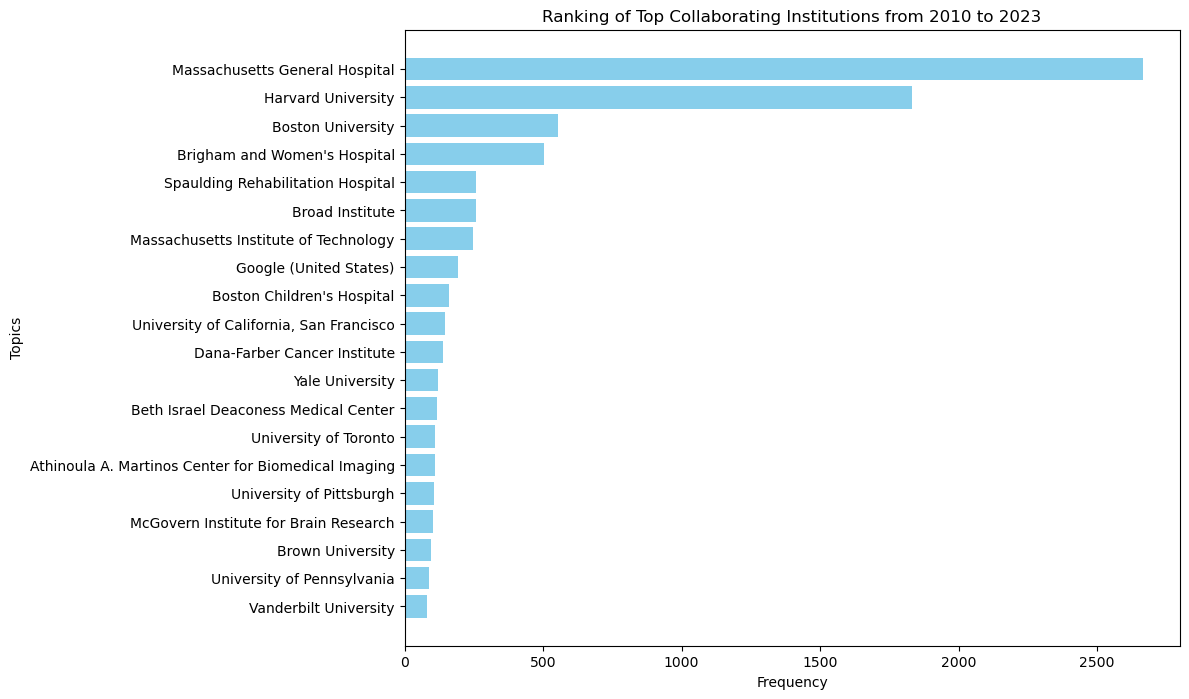

In [21]:
collaboration_counts = {}

for publication in data:
    year = publication.get('publication_year')
    if begin <= year <= end:
        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                inst_id = institution['id']
                inst_name = institution.get('display_name', inst_id)  # Use institution ID if name is not available
                if inst_id != home_institution:  # Exclude the home institution
                    if inst_name in collaboration_counts:
                        collaboration_counts[inst_name] += 1
                    else:
                        collaboration_counts[inst_name] = 1
                            
plot_ranking(collaboration_counts, begin, end, top_n=top_n_topics, title="Top Collaborating Institutions", save_plot=True, ppt_filename=ppt_filename)

## Ranking of highest-ranking collaboarating countries over the time span

Plot saved as Top Collaborating Countries_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


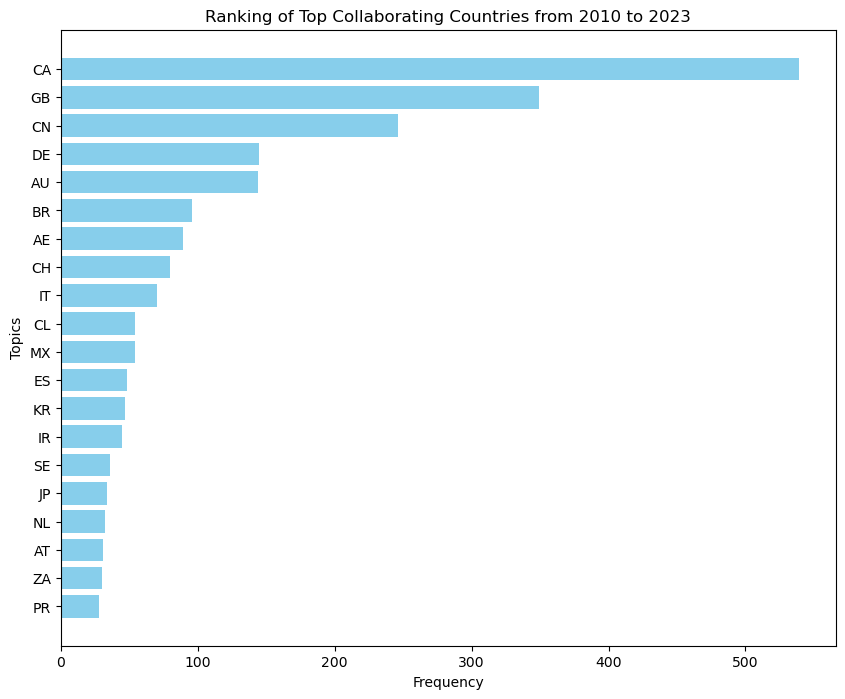

In [22]:
collaboration_counts = {}

for publication in data:
    year = publication.get('publication_year')
    if begin <= year <= end:
        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                country_code = institution.get('country_code')
                if country_code and country_code != home_country_code:  # Exclude the home country
                    if country_code in collaboration_counts:
                        collaboration_counts[country_code] += 1
                    else:
                        collaboration_counts[country_code] = 1

plot_ranking(collaboration_counts, begin, end, top_n=top_n_topics, title="Top Collaborating Countries", save_plot=True, ppt_filename=ppt_filename)

## Ranking of highest-ranking journals, venues, etc where the Home institution published

C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:24: UserWarning: Glyph 152 (\x98) missing from current font.
  plt.savefig(file_name, dpi=300)  # Save the plot with high resolution
C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:24: UserWarning: Glyph 156 (\x9c) missing from current font.
  plt.savefig(file_name, dpi=300)  # Save the plot with high resolution


Plot saved as Top Journals where we publish_2010_2023.png
Folder already exists: .


C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:42: UserWarning: Glyph 152 (\x98) missing from current font.
  plt.savefig(buf, format='png', dpi=300)
C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:42: UserWarning: Glyph 156 (\x9c) missing from current font.
  plt.savefig(buf, format='png', dpi=300)


Plot added to I158133745_statistics.ppt


C:\Users\ad1532\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 152 (\x98) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ad1532\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 156 (\x9c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


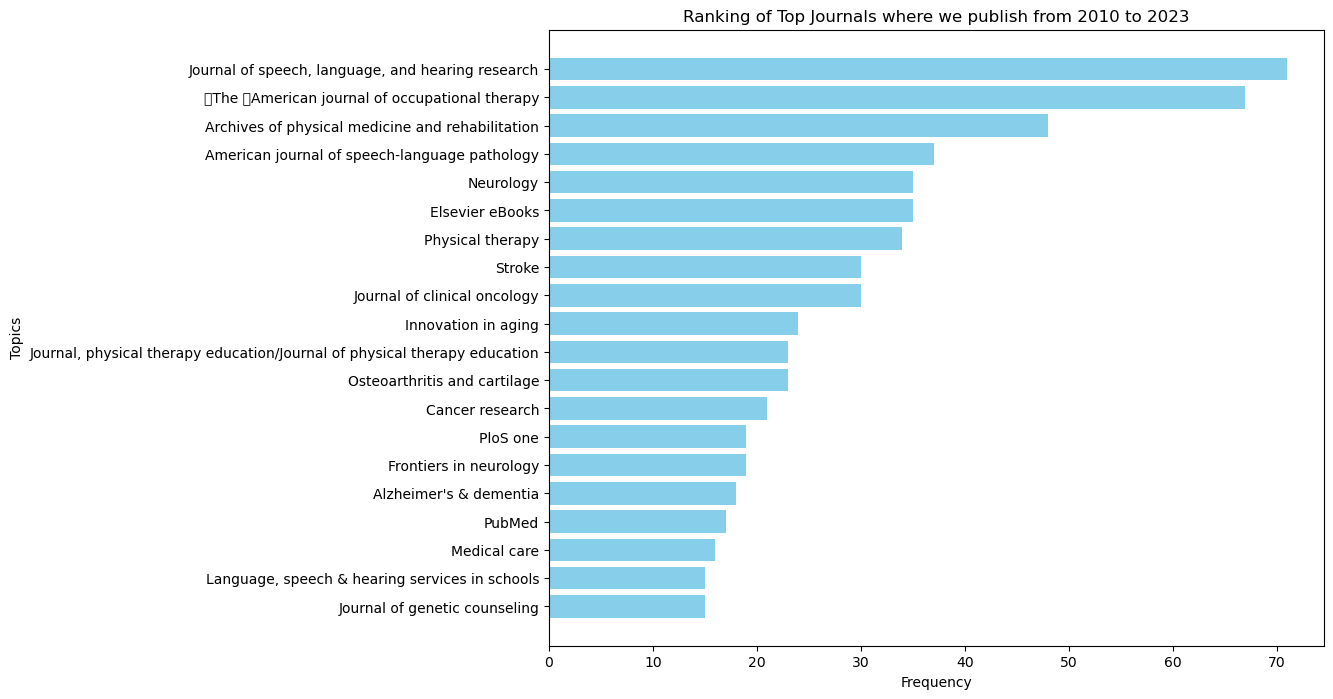

In [23]:
journal_counts = {}
journal_names_map = {}

for publication in data:
    year = publication.get('publication_year')
    if begin <= year <= end:
        # Ensure 'primary_location' is a dictionary before accessing 'source'
        primary_location = publication.get('primary_location', {})
        source = primary_location.get('source') if isinstance(primary_location, dict) else None
        journal_id = source.get('id') if source else None
        journal_name = source.get('display_name') if source else None  # Assuming 'name' is the key for the journal name

        if journal_id and journal_name:
            # Map journal ID to name
            journal_names_map[journal_id] = journal_name

            # Count occurrences by journal ID
            if journal_id in journal_counts:
                journal_counts[journal_id] += 1
            else:
                journal_counts[journal_id] = 1

journal_counts_by_name = {journal_names_map[journal_id]: count for journal_id, count in journal_counts.items()}


plot_ranking(journal_counts_by_name, begin, end, top_n=top_n_topics, title="Top Journals where we publish", save_plot=True, ppt_filename=ppt_filename)

## Proportion of open-sourced works

For information about the types of open-source status, please consult https://pressbooks.bccampus.ca/posetest/chapter/other-open-access-models/#:~:text=Bronze%20open%20access%20refers%20to,is%20clearly%20marked%20for%20reuse.

Plot saved as Proportion of Open Access Publications_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


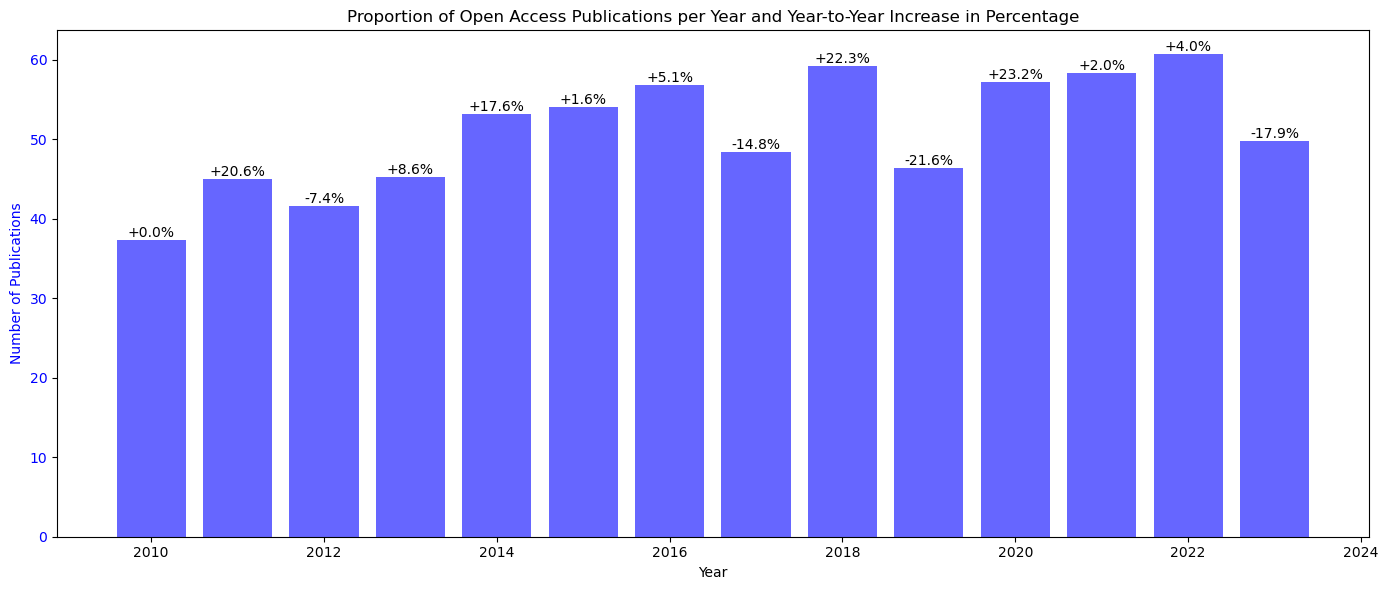

In [24]:
# Analyze the proportion of open access works per year
oa_counts_per_year = defaultdict(lambda: {'oa': 0, 'total': 0})

for work in data:
    year = work.get('publication_year')
    is_oa = work.get('open_access')["is_oa"]
    if year:
        oa_counts_per_year[year]['total'] += 1
        if is_oa:
            oa_counts_per_year[year]['oa'] += 1

# Prepare data for dynamic sizing plot
years = sorted(oa_counts_per_year.keys())
oa_proportions = {year: (oa_counts_per_year[year]['oa'] / oa_counts_per_year[year]['total']) * 100 for year in years}

# Use the function to plot the proportion of open access publications per year
plot_publications_with_dynamic_sizing(oa_proportions, begin, end, title="Proportion of Open Access Publications", save_plot=True, ppt_filename=ppt_filename)

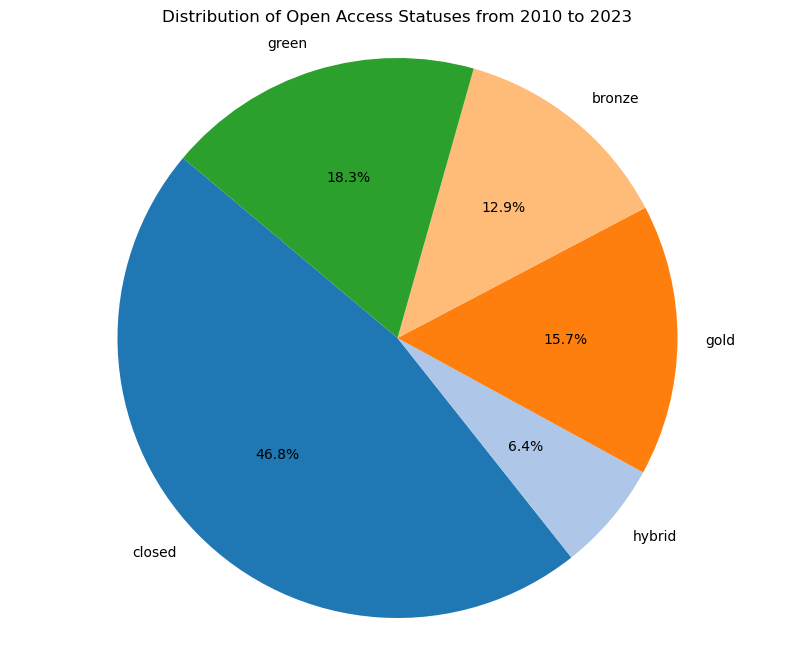

In [25]:
oa_status_counts = defaultdict(int)

for work in data:
    year = work.get('publication_year')
    if year and begin <= year <= end:  # Filter to only consider works within the specified range
        open_access_info = work.get('open_access', {})  # Get the open_access dictionary safely
        oa_status = open_access_info.get("oa_status", "Unknown")  # Default to "Unknown" if oa_status isn't present
        oa_status_counts[oa_status] += 1

# Prepare data for the pie chart
statuses = list(oa_status_counts.keys())
counts = list(oa_status_counts.values())

# Generate a color map
colors = plt.cm.tab20(range(len(statuses)))  # 'tab20' provides 20 distinct colors

# Plotting
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=statuses, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Open Access Statuses from {} to {}'.format(begin, end))
plt.show()

## Funding sources

We collect the grants whenever they are available. Due to massiviely missing data, this may not be very informative!

We also check that NIH is not registered when the grant comes from a sub-NIH institute (see list https://www.nih.gov/institutes-nih/list-institutes-centers); however, this never happens in the data

Plot saved as Top funding sources (No Funding Info for 83.98% of publications)_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


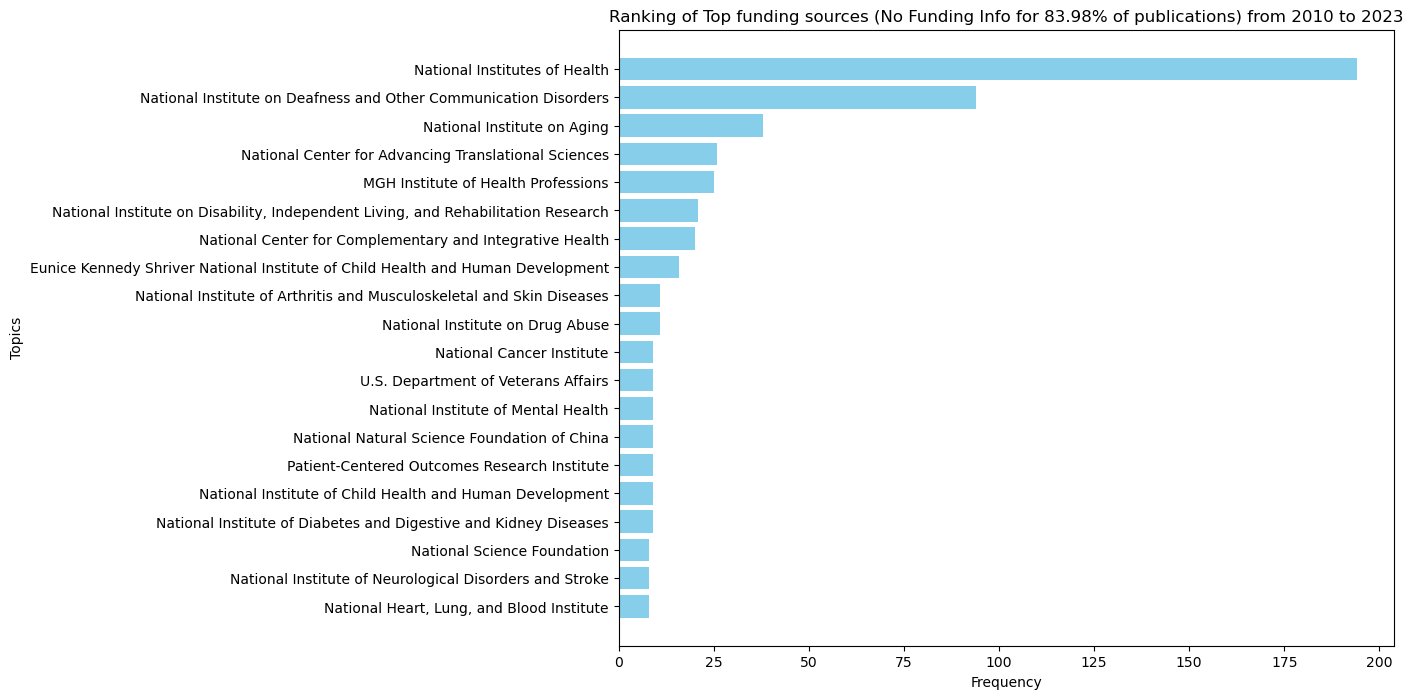

In [26]:
NIH_ID = "https://openalex.org/F4320332161"
sub_NIH_institutes_IDs = ["https://openalex.org/F4320337337", "https://openalex.org/F4320337611", 
                          "https://openalex.org/F4320337352", "https://openalex.org/F4320337351", 
                          "https://openalex.org/F4320337362", "https://openalex.org/F4320337338",
                          "https://openalex.org/F4320337363", "https://openalex.org/F4320337604",
                         "https://openalex.org/F4320337346", "https://openalex.org/F4320337359", 
                          "https://openalex.org/F4320337534", "https://openalex.org/F4320337347",
                         "https://openalex.org/F4320337364", "https://openalex.org/F4320337357", 
                          "https://openalex.org/F4320337354", "https://openalex.org/F4320319990",
                         "https://openalex.org/F4320337355", "https://openalex.org/F4320337112", 
                          "https://openalex.org/F4320337353", "https://openalex.org/F4320309123"]

# Initialize the counter for grant counts and variables to track funding status
grant_counts = Counter()
total_publications = 0
publications_without_funding = 0

for publication in data:
    year = publication.get('publication_year')
    if year and begin <= year <= end:  # Check if the publication year is within the specified range
        total_publications += 1  # Increment total publications count
        grants = publication.get('grants', [])
        
        if not grants:  # Check if the grants list is empty or missing
            publications_without_funding += 1
        else:
            for grant in grants:
                grant_id = grant.get('funder_display_name')  # Assuming each grant has a funder's display name
                funder = grant.get('funder')  # Assuming additional field for detailed funder ID
                if grant_id and funder:
                    # Check if both NIH_ID and any sub_NIH_institutes_ID are in the funder field
                    if NIH_ID in funder and any(sub_id in funder for sub_id in sub_NIH_institutes_IDs):
                        continue  # Skip this grant for counting
                    grant_counts[grant_id] += 1

# Calculate the proportion of publications without funding information
if total_publications > 0:
    no_funding_proportion = (publications_without_funding / total_publications) * 100
else:
    no_funding_proportion = 0

plot_ranking(grant_counts, begin, end, top_n=top_n_topics, title=f"Top funding sources (No Funding Info for {no_funding_proportion:.2f}% of publications)", save_plot=True, ppt_filename=ppt_filename)

## citations received per year

Plot saved as Citation Counts per Year_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


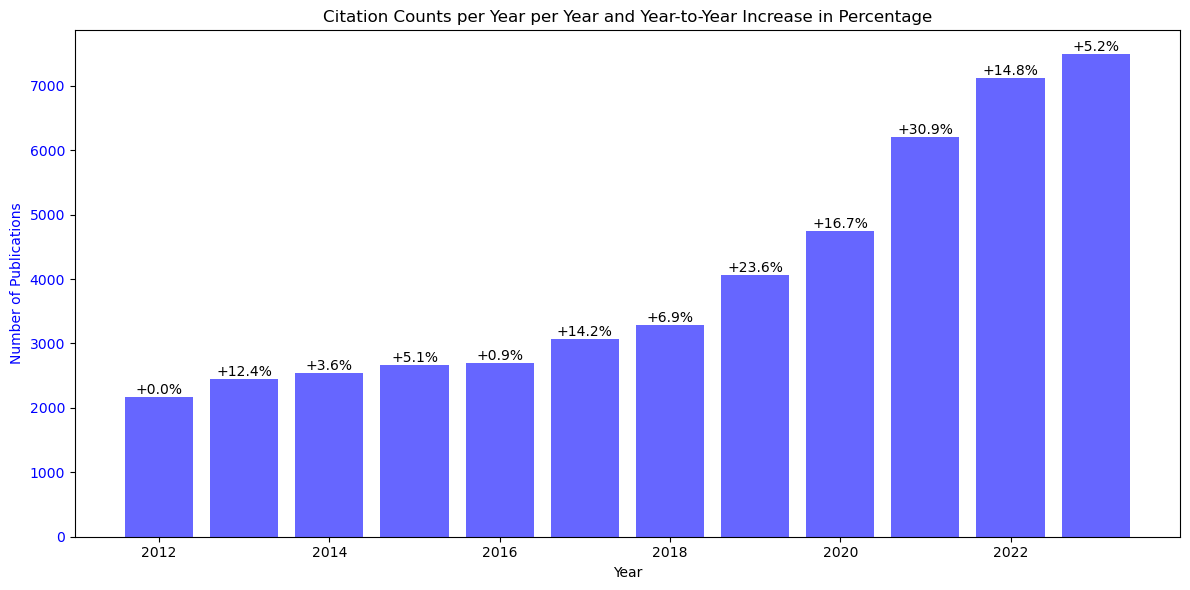

In [27]:
citation_counts_by_year = defaultdict(int)

for publication in data:
    counts_by_year = publication.get('counts_by_year', [])
    for count in counts_by_year:
        year = count.get('year')
        cited_by_count = count.get('cited_by_count', 0)
        citation_counts_by_year[year] += cited_by_count

# Convert the defaultdict to a regular dict for plotting
citation_counts_by_year = dict(citation_counts_by_year)

# Call the plotting function with the aggregated citation data
plot_publications_with_dynamic_sizing(citation_counts_by_year, begin, end, title="Citation Counts per Year", save_plot=True, ppt_filename=ppt_filename)

## Some statistics about the papers that have cited us (weighted by how many times they cite us)

First, let's collect all of these papers. This may take minutes to hours.

In [28]:
data_they_cite_us = []
base_url = "https://api.openalex.org/works"

for publication in tqdm(data):
    publication_id = publication.get('id')
    if publication_id:
        # Forming the URL to query works that cite this publication
        query_url = f"{base_url}?filter=cites:{publication_id}"
        
        try:
            response = requests.get(query_url)
            if response.status_code == 200:
                response_data = response.json()
                works = response_data.get('results', [])
                
                # Add all citing work identifiers to the set
                for work in works:
                    data_they_cite_us.append(work)
                
                #print(f"Collected citing works for publication ID: {publication_id}")
            else:
                print(f"Failed to fetch citing works for publication ID: {publication_id}")
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")

# Convert the set to a list if necessary
list_data_they_cite_us = list(data_they_cite_us)
print(f"Total unique works that cite our publications: {len(list_data_they_cite_us)}")


  0%|          | 5/3106 [00:00<06:20,  8.16it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4397002565
Failed to fetch citing works for publication ID: https://openalex.org/W4399275717


  0%|          | 11/3106 [00:01<09:00,  5.72it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4398217745


  1%|          | 18/3106 [00:02<05:07, 10.03it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4396583224
Failed to fetch citing works for publication ID: https://openalex.org/W4392261509
Failed to fetch citing works for publication ID: https://openalex.org/W4396920086
Failed to fetch citing works for publication ID: https://openalex.org/W4398166199


  1%|          | 20/3106 [00:02<05:44,  8.95it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4399067255


  1%|          | 25/3106 [00:03<05:37,  9.13it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4396541900
Failed to fetch citing works for publication ID: https://openalex.org/W4395466670
Failed to fetch citing works for publication ID: https://openalex.org/W4394962429


  1%|          | 27/3106 [00:03<04:56, 10.40it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4394853229
Failed to fetch citing works for publication ID: https://openalex.org/W4392904549


  1%|          | 34/3106 [00:04<05:36,  9.14it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4393940817
Failed to fetch citing works for publication ID: https://openalex.org/W4393853140
Failed to fetch citing works for publication ID: https://openalex.org/W4390775376


  1%|          | 38/3106 [00:04<04:42, 10.87it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391098161
Failed to fetch citing works for publication ID: https://openalex.org/W4392528890
Failed to fetch citing works for publication ID: https://openalex.org/W4392603302


  1%|▏         | 44/3106 [00:05<07:02,  7.24it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4394725275
Failed to fetch citing works for publication ID: https://openalex.org/W4394953656


  2%|▏         | 52/3106 [00:06<04:39, 10.94it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4393081407
Failed to fetch citing works for publication ID: https://openalex.org/W4393096583
Failed to fetch citing works for publication ID: https://openalex.org/W4393039210
Failed to fetch citing works for publication ID: https://openalex.org/W4393005277


  2%|▏         | 54/3106 [00:06<04:13, 12.03it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392956156
Failed to fetch citing works for publication ID: https://openalex.org/W4392940500


  2%|▏         | 60/3106 [00:07<06:03,  8.38it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392753073
Failed to fetch citing works for publication ID: https://openalex.org/W4392683777
Failed to fetch citing works for publication ID: https://openalex.org/W4392717625


  2%|▏         | 62/3106 [00:07<05:37,  9.02it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392652589


  2%|▏         | 70/3106 [00:08<05:04,  9.97it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392502257
Failed to fetch citing works for publication ID: https://openalex.org/W4392369324
Failed to fetch citing works for publication ID: https://openalex.org/W4390582689
Failed to fetch citing works for publication ID: https://openalex.org/W4391460211


  2%|▏         | 72/3106 [00:09<05:42,  8.87it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391796426


  2%|▏         | 77/3106 [00:09<05:28,  9.21it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392657495
Failed to fetch citing works for publication ID: https://openalex.org/W4392231347
Failed to fetch citing works for publication ID: https://openalex.org/W4392167172


  3%|▎         | 79/3106 [00:09<04:51, 10.38it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392109298


  3%|▎         | 85/3106 [00:10<06:02,  8.32it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391817457
Failed to fetch citing works for publication ID: https://openalex.org/W4391746478
Failed to fetch citing works for publication ID: https://openalex.org/W4391597769
Failed to fetch citing works for publication ID: https://openalex.org/W4391529254


  3%|▎         | 92/3106 [00:11<08:16,  6.08it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4389741991
Failed to fetch citing works for publication ID: https://openalex.org/W4391430076


  3%|▎         | 99/3106 [00:12<06:03,  8.27it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391888379
Failed to fetch citing works for publication ID: https://openalex.org/W4392347131
Failed to fetch citing works for publication ID: https://openalex.org/W4392786721


  3%|▎         | 101/3106 [00:12<05:05,  9.85it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391397676
Failed to fetch citing works for publication ID: https://openalex.org/W4391443241


  3%|▎         | 108/3106 [00:13<06:00,  8.31it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391110031
Failed to fetch citing works for publication ID: https://openalex.org/W4391077339
Failed to fetch citing works for publication ID: https://openalex.org/W4390940048


  4%|▎         | 110/3106 [00:14<05:02,  9.91it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4391420540


  4%|▎         | 116/3106 [00:14<05:44,  8.68it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4390630702
Failed to fetch citing works for publication ID: https://openalex.org/W4391100824
Failed to fetch citing works for publication ID: https://openalex.org/W3180300872


  4%|▍         | 118/3106 [00:15<04:56, 10.07it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4389305952


  4%|▍         | 124/3106 [00:15<05:54,  8.40it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4392252373
Failed to fetch citing works for publication ID: https://openalex.org/W4394739495
Failed to fetch citing works for publication ID: https://openalex.org/W4394939260
Failed to fetch citing works for publication ID: https://openalex.org/W4394939301


  4%|▍         | 132/3106 [00:16<05:03,  9.81it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4390269869
Failed to fetch citing works for publication ID: https://openalex.org/W4389894280
Failed to fetch citing works for publication ID: https://openalex.org/W4389900221


  4%|▍         | 136/3106 [00:17<04:10, 11.87it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4389953861
Failed to fetch citing works for publication ID: https://openalex.org/W4389489132
Failed to fetch citing works for publication ID: https://openalex.org/W4389490909


  5%|▍         | 142/3106 [00:17<05:45,  8.59it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4389393608
Failed to fetch citing works for publication ID: https://openalex.org/W4389330355
Failed to fetch citing works for publication ID: https://openalex.org/W4376271834


  5%|▍         | 144/3106 [00:18<05:18,  9.29it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4389120443


  5%|▍         | 150/3106 [00:18<05:51,  8.42it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4390065398
Failed to fetch citing works for publication ID: https://openalex.org/W4390082077
Failed to fetch citing works for publication ID: https://openalex.org/W4390192417


  5%|▍         | 152/3106 [00:19<05:04,  9.71it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4390196246


  5%|▌         | 160/3106 [00:20<04:56,  9.92it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4389085286
Failed to fetch citing works for publication ID: https://openalex.org/W4389029270
Failed to fetch citing works for publication ID: https://openalex.org/W4389029788
Failed to fetch citing works for publication ID: https://openalex.org/W4389030348


  5%|▌         | 166/3106 [00:21<05:53,  8.31it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4387085793
Failed to fetch citing works for publication ID: https://openalex.org/W4388761607
Failed to fetch citing works for publication ID: https://openalex.org/W4388771760


  6%|▌         | 175/3106 [00:22<04:41, 10.43it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4388456455
Failed to fetch citing works for publication ID: https://openalex.org/W4389944710
Failed to fetch citing works for publication ID: https://openalex.org/W4387002741
Failed to fetch citing works for publication ID: https://openalex.org/W4387580524
Failed to fetch citing works for publication ID: https://openalex.org/W4385647419


  6%|▌         | 182/3106 [00:23<06:14,  7.80it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4386133687
Failed to fetch citing works for publication ID: https://openalex.org/W4387660753


  6%|▌         | 189/3106 [00:24<07:36,  6.39it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4388100805


  6%|▌         | 194/3106 [00:25<06:49,  7.11it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4387730027
Failed to fetch citing works for publication ID: https://openalex.org/W4387702265


  6%|▋         | 200/3106 [00:26<05:58,  8.11it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4387407540
Failed to fetch citing works for publication ID: https://openalex.org/W4387441011
Failed to fetch citing works for publication ID: https://openalex.org/W4387296287


  7%|▋         | 202/3106 [00:26<04:55,  9.82it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4384499991
Failed to fetch citing works for publication ID: https://openalex.org/W4383893998


  7%|▋         | 209/3106 [00:27<06:09,  7.85it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4385814193
Failed to fetch citing works for publication ID: https://openalex.org/W4380486099
Failed to fetch citing works for publication ID: https://openalex.org/W4386100352


  7%|▋         | 216/3106 [00:28<05:46,  8.35it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4387114811
Failed to fetch citing works for publication ID: https://openalex.org/W4387081427
Failed to fetch citing works for publication ID: https://openalex.org/W4387118464


  7%|▋         | 218/3106 [00:28<05:04,  9.49it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4386837793


  7%|▋         | 224/3106 [00:29<06:22,  7.53it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4386466171
Failed to fetch citing works for publication ID: https://openalex.org/W4386386463


  7%|▋         | 230/3106 [00:30<05:45,  8.33it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4382561711
Failed to fetch citing works for publication ID: https://openalex.org/W4387079294
Failed to fetch citing works for publication ID: https://openalex.org/W4384436055


  7%|▋         | 232/3106 [00:30<04:48,  9.95it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4386064468
Failed to fetch citing works for publication ID: https://openalex.org/W4386346892


  8%|▊         | 241/3106 [00:31<04:35, 10.42it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4386020057
Failed to fetch citing works for publication ID: https://openalex.org/W4320709954
Failed to fetch citing works for publication ID: https://openalex.org/W4385268093
Failed to fetch citing works for publication ID: https://openalex.org/W4385898405
Failed to fetch citing works for publication ID: https://openalex.org/W4385778430


  8%|▊         | 248/3106 [00:32<05:36,  8.48it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4387615346
Failed to fetch citing works for publication ID: https://openalex.org/W4387620864
Failed to fetch citing works for publication ID: https://openalex.org/W4384923687


  8%|▊         | 250/3106 [00:32<04:50,  9.83it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4385548173


  8%|▊         | 256/3106 [00:33<06:17,  7.54it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4383316032
Failed to fetch citing works for publication ID: https://openalex.org/W4381056706


  8%|▊         | 262/3106 [00:34<05:58,  7.93it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4385294654
Failed to fetch citing works for publication ID: https://openalex.org/W4385356480
Failed to fetch citing works for publication ID: https://openalex.org/W4385231081


  8%|▊         | 264/3106 [00:34<04:55,  9.61it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4385185888
Failed to fetch citing works for publication ID: https://openalex.org/W4384626513


  9%|▊         | 271/3106 [00:35<05:04,  9.30it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4381893913
Failed to fetch citing works for publication ID: https://openalex.org/W4384492940
Failed to fetch citing works for publication ID: https://openalex.org/W4376610545


  9%|▉         | 273/3106 [00:35<04:20, 10.86it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4362576925
Failed to fetch citing works for publication ID: https://openalex.org/W4366978149


  9%|▉         | 281/3106 [00:36<05:13,  9.01it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4385309766
Failed to fetch citing works for publication ID: https://openalex.org/W4385309936
Failed to fetch citing works for publication ID: https://openalex.org/W4328104243


  9%|▉         | 283/3106 [00:36<05:14,  8.98it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4382798396


  9%|▉         | 288/3106 [00:37<05:45,  8.16it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4385310007
Failed to fetch citing works for publication ID: https://openalex.org/W4385881677
Failed to fetch citing works for publication ID: https://openalex.org/W4386215248


  9%|▉         | 290/3106 [00:37<04:51,  9.66it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4382682280


 10%|▉         | 296/3106 [00:38<05:57,  7.85it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4380291113
Failed to fetch citing works for publication ID: https://openalex.org/W4380152629
Failed to fetch citing works for publication ID: https://openalex.org/W4380153725


 10%|▉         | 298/3106 [00:38<05:05,  9.18it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4379508316


 10%|▉         | 304/3106 [00:39<04:59,  9.37it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4309862746
Failed to fetch citing works for publication ID: https://openalex.org/W4312094620
Failed to fetch citing works for publication ID: https://openalex.org/W4318014995


 10%|▉         | 306/3106 [00:39<04:30, 10.37it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4377564750


 10%|█         | 314/3106 [00:40<05:14,  8.87it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4378373669
Failed to fetch citing works for publication ID: https://openalex.org/W4378173074
Failed to fetch citing works for publication ID: https://openalex.org/W4378172903


 10%|█         | 322/3106 [00:41<04:36, 10.08it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4377011248
Failed to fetch citing works for publication ID: https://openalex.org/W4376871161
Failed to fetch citing works for publication ID: https://openalex.org/W4376872688
Failed to fetch citing works for publication ID: https://openalex.org/W4377100627


 10%|█         | 324/3106 [00:41<05:22,  8.62it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4364355942


 11%|█         | 329/3106 [00:42<06:17,  7.36it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4367604112
Failed to fetch citing works for publication ID: https://openalex.org/W4367606190


 11%|█         | 335/3106 [00:43<05:39,  8.16it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4387270101
Failed to fetch citing works for publication ID: https://openalex.org/W4367548821
Failed to fetch citing works for publication ID: https://openalex.org/W4367174920


 11%|█         | 338/3106 [00:43<05:10,  8.92it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4367174213


 11%|█         | 343/3106 [00:44<05:29,  8.38it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4366551359
Failed to fetch citing works for publication ID: https://openalex.org/W4366281349
Failed to fetch citing works for publication ID: https://openalex.org/W4366275710


 11%|█         | 345/3106 [00:44<04:38,  9.90it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4366351002


 11%|█▏        | 352/3106 [00:45<05:45,  7.98it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4365504510
Failed to fetch citing works for publication ID: https://openalex.org/W4363625568
Failed to fetch citing works for publication ID: https://openalex.org/W4362735067


 11%|█▏        | 357/3106 [00:46<06:32,  7.01it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4319339016
Failed to fetch citing works for publication ID: https://openalex.org/W4362597114
Failed to fetch citing works for publication ID: https://openalex.org/W4362523969


 12%|█▏        | 360/3106 [00:46<05:56,  7.70it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4366211845


 12%|█▏        | 365/3106 [00:47<05:47,  7.89it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4360599765
Failed to fetch citing works for publication ID: https://openalex.org/W4366000657
Failed to fetch citing works for publication ID: https://openalex.org/W4385194476


 12%|█▏        | 367/3106 [00:47<04:47,  9.51it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4386868500


 12%|█▏        | 375/3106 [00:48<04:23, 10.36it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4328049681
Failed to fetch citing works for publication ID: https://openalex.org/W4328124224
Failed to fetch citing works for publication ID: https://openalex.org/W4327896525
Failed to fetch citing works for publication ID: https://openalex.org/W4327895133


 12%|█▏        | 377/3106 [00:48<04:43,  9.64it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4327902080


 12%|█▏        | 384/3106 [00:49<04:45,  9.54it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4318261672
Failed to fetch citing works for publication ID: https://openalex.org/W4323567497
Failed to fetch citing works for publication ID: https://openalex.org/W4323567527
Failed to fetch citing works for publication ID: https://openalex.org/W4322767816


 13%|█▎        | 389/3106 [00:50<06:29,  6.98it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4308297350
Failed to fetch citing works for publication ID: https://openalex.org/W4312055780
Failed to fetch citing works for publication ID: https://openalex.org/W4322719817


 13%|█▎        | 396/3106 [00:51<05:18,  8.51it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4362519111
Failed to fetch citing works for publication ID: https://openalex.org/W4322489649
Failed to fetch citing works for publication ID: https://openalex.org/W4321595768


 13%|█▎        | 400/3106 [00:51<03:54, 11.53it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4321367172
Failed to fetch citing works for publication ID: https://openalex.org/W4321165811
Failed to fetch citing works for publication ID: https://openalex.org/W4321003471


 13%|█▎        | 406/3106 [00:52<05:33,  8.09it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4318261331
Failed to fetch citing works for publication ID: https://openalex.org/W4319790285
Failed to fetch citing works for publication ID: https://openalex.org/W4319067276


 13%|█▎        | 408/3106 [00:53<04:57,  9.06it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4319007286


 13%|█▎        | 415/3106 [00:54<05:24,  8.29it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4318778230
Failed to fetch citing works for publication ID: https://openalex.org/W4307501398
Failed to fetch citing works for publication ID: https://openalex.org/W4318215289


 14%|█▎        | 421/3106 [00:54<05:39,  7.90it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4317651129
Failed to fetch citing works for publication ID: https://openalex.org/W4317567932
Failed to fetch citing works for publication ID: https://openalex.org/W4318754217


 14%|█▍        | 428/3106 [00:55<05:25,  8.23it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4313509112
Failed to fetch citing works for publication ID: https://openalex.org/W4313488743
Failed to fetch citing works for publication ID: https://openalex.org/W4313489189


 14%|█▍        | 430/3106 [00:56<04:36,  9.67it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W3113411670
Failed to fetch citing works for publication ID: https://openalex.org/W4362594162


 14%|█▍        | 437/3106 [00:57<06:17,  7.07it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4378781582
Failed to fetch citing works for publication ID: https://openalex.org/W4310723226


 14%|█▍        | 445/3106 [00:58<04:16, 10.39it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4377077696
Failed to fetch citing works for publication ID: https://openalex.org/W4380320712
Failed to fetch citing works for publication ID: https://openalex.org/W4384433697
Failed to fetch citing works for publication ID: https://openalex.org/W4386909973
Failed to fetch citing works for publication ID: https://openalex.org/W4392257900


 15%|█▍        | 452/3106 [00:59<04:56,  8.95it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4312019132
Failed to fetch citing works for publication ID: https://openalex.org/W4313416798
Failed to fetch citing works for publication ID: https://openalex.org/W4313308054


 15%|█▍        | 454/3106 [00:59<04:13, 10.45it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4308735746
Failed to fetch citing works for publication ID: https://openalex.org/W4310706846


 15%|█▍        | 461/3106 [01:00<04:50,  9.10it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4310222813
Failed to fetch citing works for publication ID: https://openalex.org/W4309842645
Failed to fetch citing works for publication ID: https://openalex.org/W4309791203


 15%|█▍        | 463/3106 [01:00<04:13, 10.42it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4309496557
Failed to fetch citing works for publication ID: https://openalex.org/W4309787410


 15%|█▌        | 469/3106 [01:01<06:08,  7.16it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4308545190
Failed to fetch citing works for publication ID: https://openalex.org/W4309317898
Failed to fetch citing works for publication ID: https://openalex.org/W4309165080


 15%|█▌        | 472/3106 [01:01<05:21,  8.20it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4308933462


 15%|█▌        | 476/3106 [01:02<07:08,  6.14it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4293529084
Failed to fetch citing works for publication ID: https://openalex.org/W4308407022


 15%|█▌        | 479/3106 [01:02<06:21,  6.89it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4307723473


 16%|█▌        | 484/3106 [01:03<05:39,  7.73it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4304978780
Failed to fetch citing works for publication ID: https://openalex.org/W4308394515
Failed to fetch citing works for publication ID: https://openalex.org/W4308395723


 16%|█▌        | 487/3106 [01:03<05:21,  8.15it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4308398759


 16%|█▌        | 493/3106 [01:04<04:25,  9.86it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4307727466
Failed to fetch citing works for publication ID: https://openalex.org/W4307642058
Failed to fetch citing works for publication ID: https://openalex.org/W4307327706
Failed to fetch citing works for publication ID: https://openalex.org/W4297347214


 16%|█▌        | 495/3106 [01:04<04:01, 10.83it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4306929544


 16%|█▌        | 501/3106 [01:05<06:13,  6.98it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4306316505
Failed to fetch citing works for publication ID: https://openalex.org/W4304889507


 16%|█▋        | 507/3106 [01:06<06:23,  6.79it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4302763123
Failed to fetch citing works for publication ID: https://openalex.org/W4301586630


 16%|█▋        | 511/3106 [01:07<08:54,  4.86it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4305014620


 17%|█▋        | 518/3106 [01:08<05:52,  7.35it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4294406063
Failed to fetch citing works for publication ID: https://openalex.org/W4294991862
Failed to fetch citing works for publication ID: https://openalex.org/W4295009309


 17%|█▋        | 524/3106 [01:09<06:47,  6.34it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4223525821
Failed to fetch citing works for publication ID: https://openalex.org/W4283767669


 17%|█▋        | 530/3106 [01:10<05:30,  7.80it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4293572235
Failed to fetch citing works for publication ID: https://openalex.org/W4293080055
Failed to fetch citing works for publication ID: https://openalex.org/W4293088733


 17%|█▋        | 532/3106 [01:10<04:30,  9.53it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4293192217


 17%|█▋        | 538/3106 [01:11<05:44,  7.46it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4292258100
Failed to fetch citing works for publication ID: https://openalex.org/W4291915167


 18%|█▊        | 544/3106 [01:12<05:41,  7.51it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4290729765
Failed to fetch citing works for publication ID: https://openalex.org/W4292534090
Failed to fetch citing works for publication ID: https://openalex.org/W4205817043


 18%|█▊        | 550/3106 [01:13<06:05,  7.00it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4225156035
Failed to fetch citing works for publication ID: https://openalex.org/W3217750984
Failed to fetch citing works for publication ID: https://openalex.org/W4288686026


 18%|█▊        | 557/3106 [01:14<05:37,  7.56it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4288039821
Failed to fetch citing works for publication ID: https://openalex.org/W4286447934
Failed to fetch citing works for publication ID: https://openalex.org/W4285592841


 18%|█▊        | 564/3106 [01:15<05:35,  7.59it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4284891581
Failed to fetch citing works for publication ID: https://openalex.org/W4283794545
Failed to fetch citing works for publication ID: https://openalex.org/W4225122451


 18%|█▊        | 566/3106 [01:16<04:32,  9.31it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4224922537


 18%|█▊        | 570/3106 [01:17<08:02,  5.25it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4284883894


 19%|█▊        | 577/3106 [01:18<05:38,  7.47it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4282841474
Failed to fetch citing works for publication ID: https://openalex.org/W4283747675
Failed to fetch citing works for publication ID: https://openalex.org/W4285736553


 19%|█▉        | 584/3106 [01:18<05:06,  8.23it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4304117851
Failed to fetch citing works for publication ID: https://openalex.org/W4283706514
Failed to fetch citing works for publication ID: https://openalex.org/W4283586175


 19%|█▉        | 586/3106 [01:19<04:15,  9.85it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4283645118
Failed to fetch citing works for publication ID: https://openalex.org/W4283707683


 19%|█▉        | 593/3106 [01:20<04:58,  8.41it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4282977435
Failed to fetch citing works for publication ID: https://openalex.org/W4282009471
Failed to fetch citing works for publication ID: https://openalex.org/W4282550939


 19%|█▉        | 599/3106 [01:21<06:03,  6.89it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4229069280
Failed to fetch citing works for publication ID: https://openalex.org/W4210840518
Failed to fetch citing works for publication ID: https://openalex.org/W4229025228


 20%|█▉        | 606/3106 [01:22<05:28,  7.61it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4229027752
Failed to fetch citing works for publication ID: https://openalex.org/W4224262760
Failed to fetch citing works for publication ID: https://openalex.org/W4286298691


 20%|█▉        | 613/3106 [01:23<05:25,  7.65it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4281295531
Failed to fetch citing works for publication ID: https://openalex.org/W4280647193


 20%|█▉        | 620/3106 [01:24<04:22,  9.47it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W3209605273
Failed to fetch citing works for publication ID: https://openalex.org/W4200472666
Failed to fetch citing works for publication ID: https://openalex.org/W4220915312
Failed to fetch citing works for publication ID: https://openalex.org/W4223569036


 20%|██        | 622/3106 [01:24<04:40,  8.86it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4220862562


 20%|██        | 627/3106 [01:25<05:00,  8.26it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4228997821
Failed to fetch citing works for publication ID: https://openalex.org/W4229001839
Failed to fetch citing works for publication ID: https://openalex.org/W4220776273


 20%|██        | 634/3106 [01:26<05:42,  7.22it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4220944193
Failed to fetch citing works for publication ID: https://openalex.org/W4211212688


 21%|██        | 642/3106 [01:27<04:16,  9.62it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4225322420
Failed to fetch citing works for publication ID: https://openalex.org/W4225103633
Failed to fetch citing works for publication ID: https://openalex.org/W4224937098
Failed to fetch citing works for publication ID: https://openalex.org/W4224442593


 21%|██        | 648/3106 [01:28<04:41,  8.73it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4225484376
Failed to fetch citing works for publication ID: https://openalex.org/W4224223636
Failed to fetch citing works for publication ID: https://openalex.org/W4210475883


 21%|██        | 650/3106 [01:28<04:04, 10.03it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4224008752
Failed to fetch citing works for publication ID: https://openalex.org/W4223980760


 21%|██        | 657/3106 [01:29<05:04,  8.05it/s]

Failed to fetch citing works for publication ID: https://openalex.org/W4220947540
Failed to fetch citing works for publication ID: https://openalex.org/W4225547511
Failed to fetch citing works for publication ID: https://openalex.org/W4220740915


 21%|██▏       | 663/3106 [02:45<9:21:22, 13.79s/it] 

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W4224929219 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


 22%|██▏       | 680/3106 [04:03<10:44:29, 15.94s/it]

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W4212884066 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


 42%|████▏     | 1310/3106 [07:45<7:55:23, 15.88s/it] 

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W2984292836 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


 45%|████▍     | 1386/3106 [09:20<10:49:50, 22.67s/it]

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W2908017817 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


 64%|██████▍   | 1984/3106 [13:17<7:04:34, 22.70s/it] 

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W1558849994 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


 68%|██████▊   | 2105/3106 [15:09<6:19:16, 22.73s/it]

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W1529501232 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


 95%|█████████▍| 2948/3106 [21:40<1:00:00, 22.79s/it]

Request failed: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=cites:https://openalex.org/W4231834730 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))


100%|██████████| 3106/3106 [22:26<00:00,  2.31it/s]  

Total unique works that cite our publications: 26541


## Number of different institutions citing us per year

Plot saved as Citations from Other Institutions_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


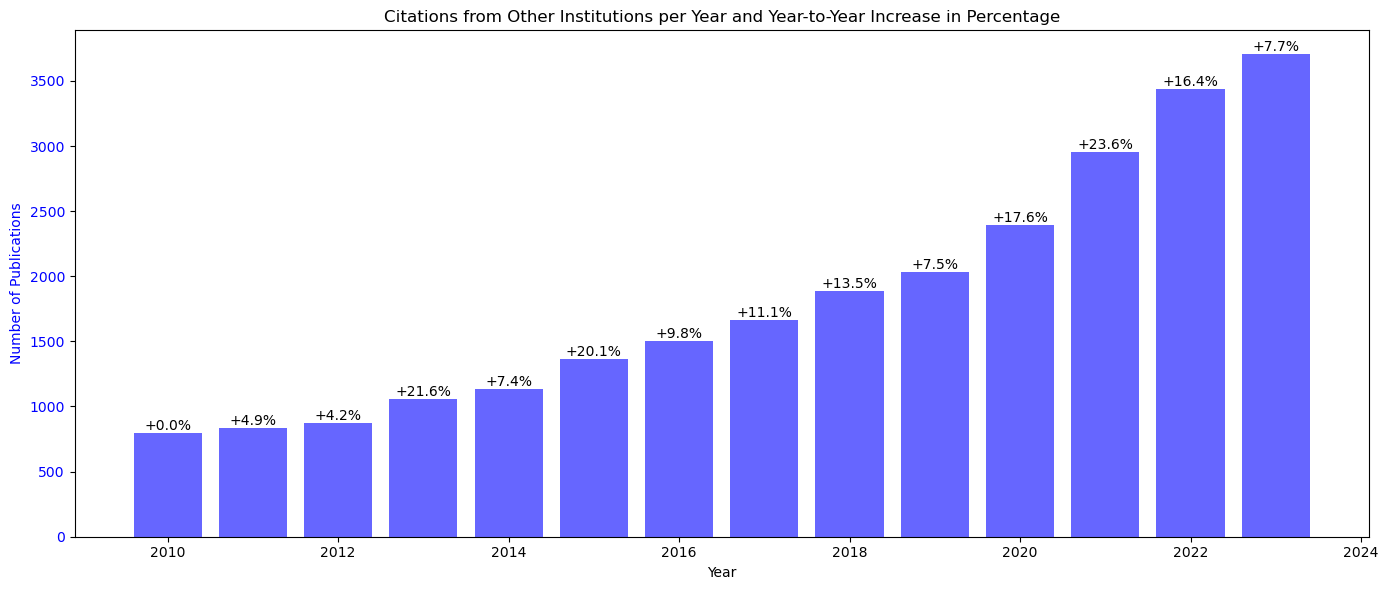

In [29]:
# Count unique collaborating institutions per year, excluding a specific institution
collaborating_institutions_counts = count_unique_collaborating_institutions_all_years(list_data_they_cite_us, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_institutions_counts, begin, end, "Citations from Other Institutions", save_plot=True, ppt_filename=ppt_filename)

## Ranking of institutions that cite us the most over the time span

Plot saved as Top Institutions that cite us the most_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


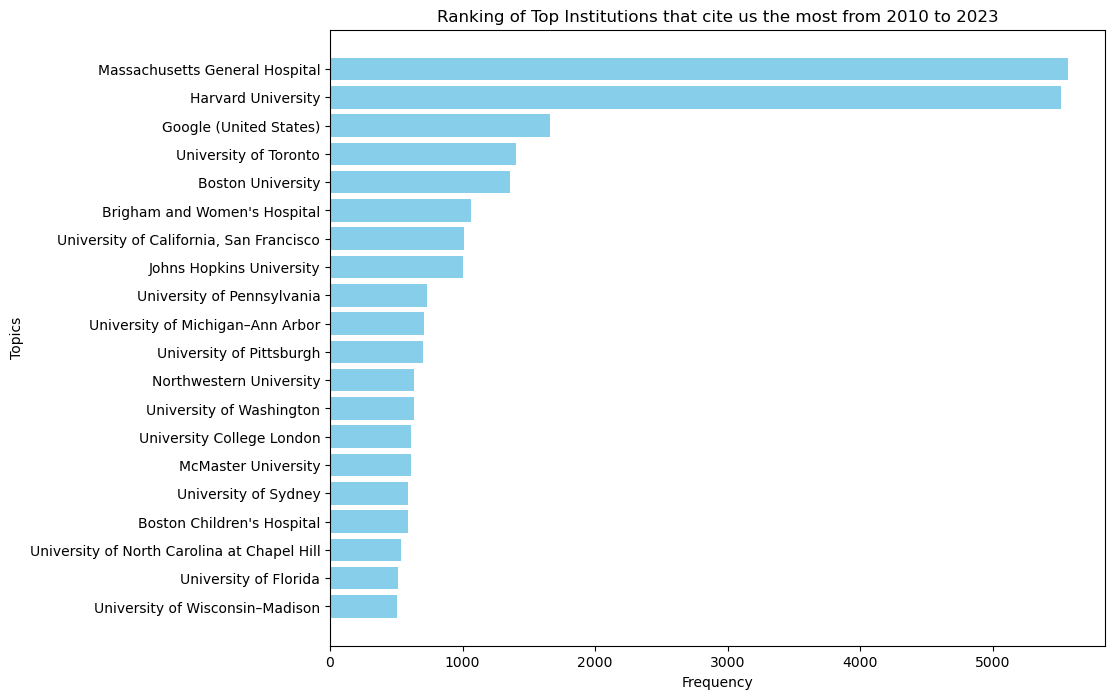

In [30]:
collaboration_counts = {}

for publication in list_data_they_cite_us:
    year = publication.get('publication_year')
    if begin <= year <= end:
        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                inst_id = institution['id']
                inst_name = institution.get('display_name', inst_id)  # Use institution ID if name is not available
                if inst_id != home_institution:  # Exclude the home institution
                    if inst_name in collaboration_counts:
                        collaboration_counts[inst_name] += 1
                    else:
                        collaboration_counts[inst_name] = 1
                            
plot_ranking(collaboration_counts, begin, end, top_n=top_n_topics, title="Top Institutions that cite us the most", save_plot=True, ppt_filename=ppt_filename)

## Number of different countries citing us per year

Plot saved as Citations from Foreign Countries_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


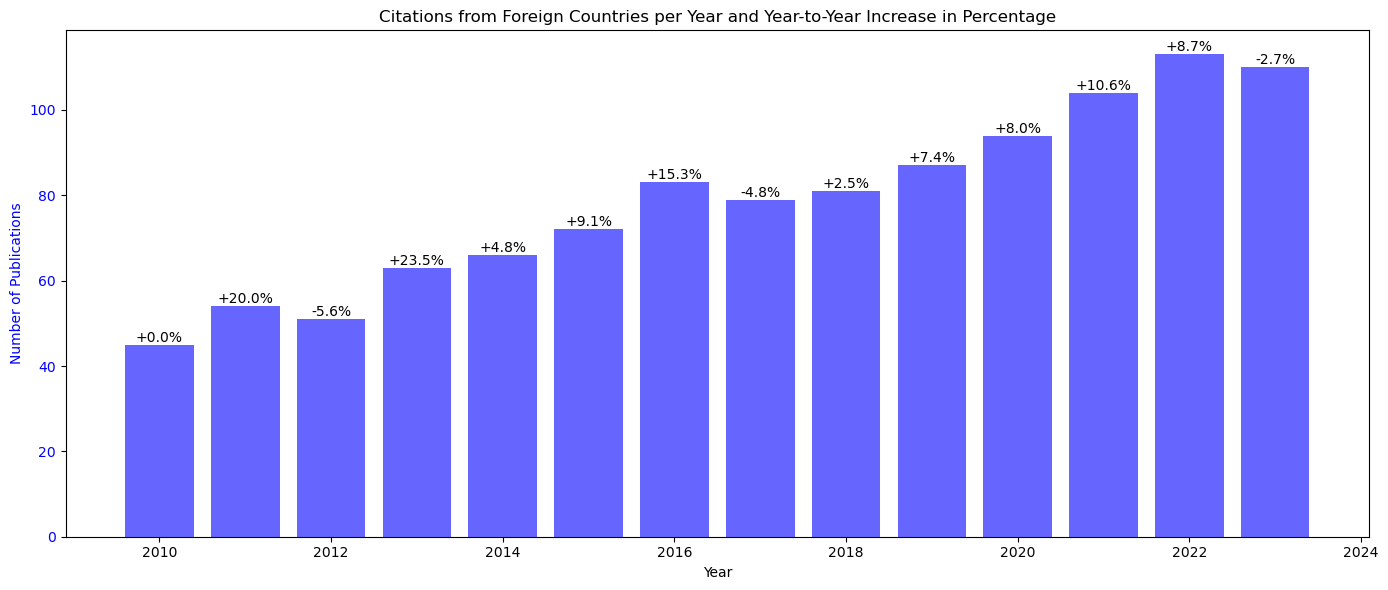

In [31]:
# Count unique collaborating countries per year, excluding a specific institution
collaborating_countries_counts = count_unique_collaborating_countries_all_years(list_data_they_cite_us, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_countries_counts, begin, end, "Citations from Foreign Countries", save_plot=True, ppt_filename=ppt_filename)

## Ranking of countries that cite us the most over the time span

Plot saved as Top Countries that cite us the most_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


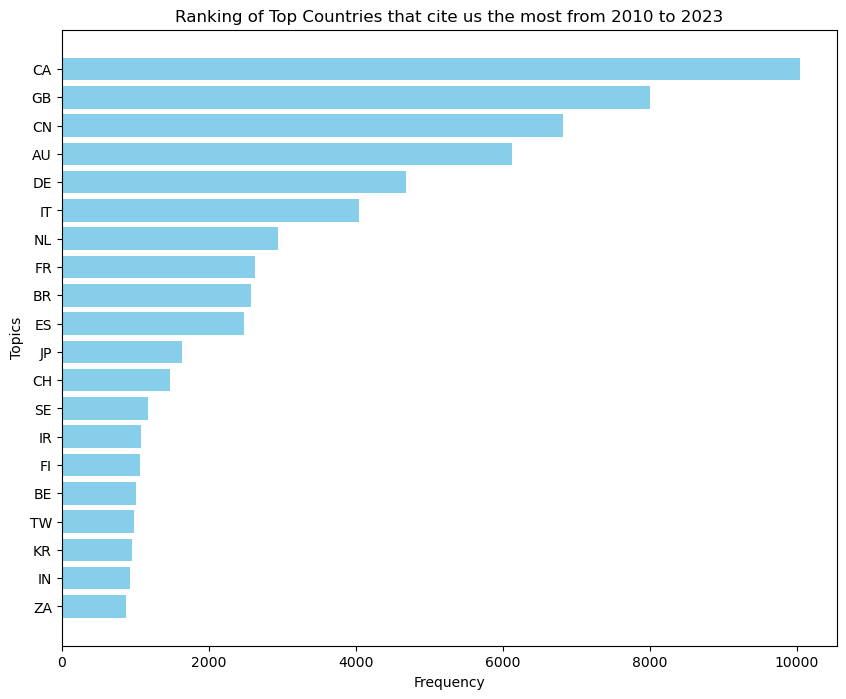

In [32]:
collaboration_counts = {}

for publication in list_data_they_cite_us:
    year = publication.get('publication_year')
    if begin <= year <= end:
        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                country_code = institution.get('country_code')
                if country_code and country_code != home_country_code:  # Exclude the home country
                    if country_code in collaboration_counts:
                        collaboration_counts[country_code] += 1
                    else:
                        collaboration_counts[country_code] = 1

plot_ranking(collaboration_counts, begin, end, top_n=top_n_topics, title="Top Countries that cite us the most", save_plot=True, ppt_filename=ppt_filename)

## Number of different journals/venues citing us per year

Plot saved as Unique Publication Venue citing us_2010_2023.png
Folder already exists: .
Plot added to I158133745_statistics.ppt


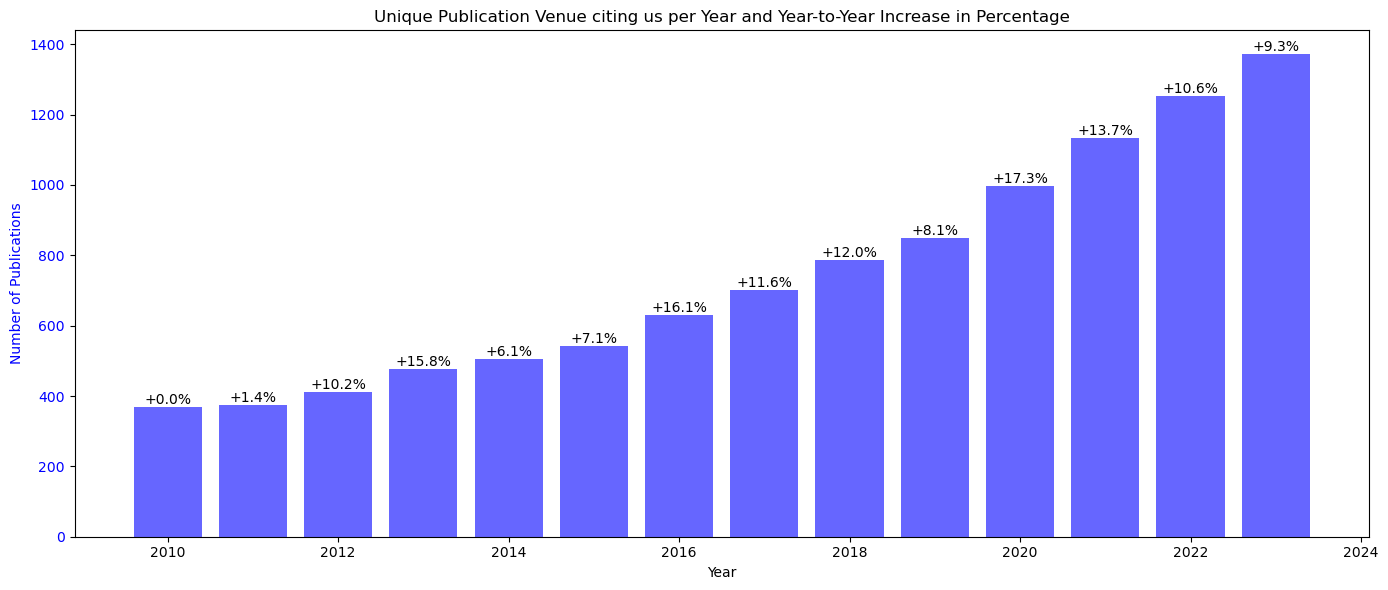

In [33]:
# Count unique venues per year with the fixed function
unique_venues_counts_fixed = count_unique_venues_all_years_corrected(list_data_they_cite_us)

# Plotting the result with the fixed data
plot_publications_with_dynamic_sizing(unique_venues_counts_fixed, begin, end, "Unique Publication Venue citing us", save_plot=True, ppt_filename=ppt_filename)

## Ranking of journals/venues that cite us the most over the time span

C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:24: UserWarning: Glyph 152 (\x98) missing from current font.
  plt.savefig(file_name, dpi=300)  # Save the plot with high resolution
C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:24: UserWarning: Glyph 156 (\x9c) missing from current font.
  plt.savefig(file_name, dpi=300)  # Save the plot with high resolution


Plot saved as Top Journals where we are cited the most_2010_2023.png
Folder already exists: .


C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:42: UserWarning: Glyph 152 (\x98) missing from current font.
  plt.savefig(buf, format='png', dpi=300)
C:\Users\ad1532\AppData\Local\Temp\ipykernel_14088\1089074255.py:42: UserWarning: Glyph 156 (\x9c) missing from current font.
  plt.savefig(buf, format='png', dpi=300)


Plot added to I158133745_statistics.ppt


C:\Users\ad1532\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 152 (\x98) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ad1532\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 156 (\x9c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


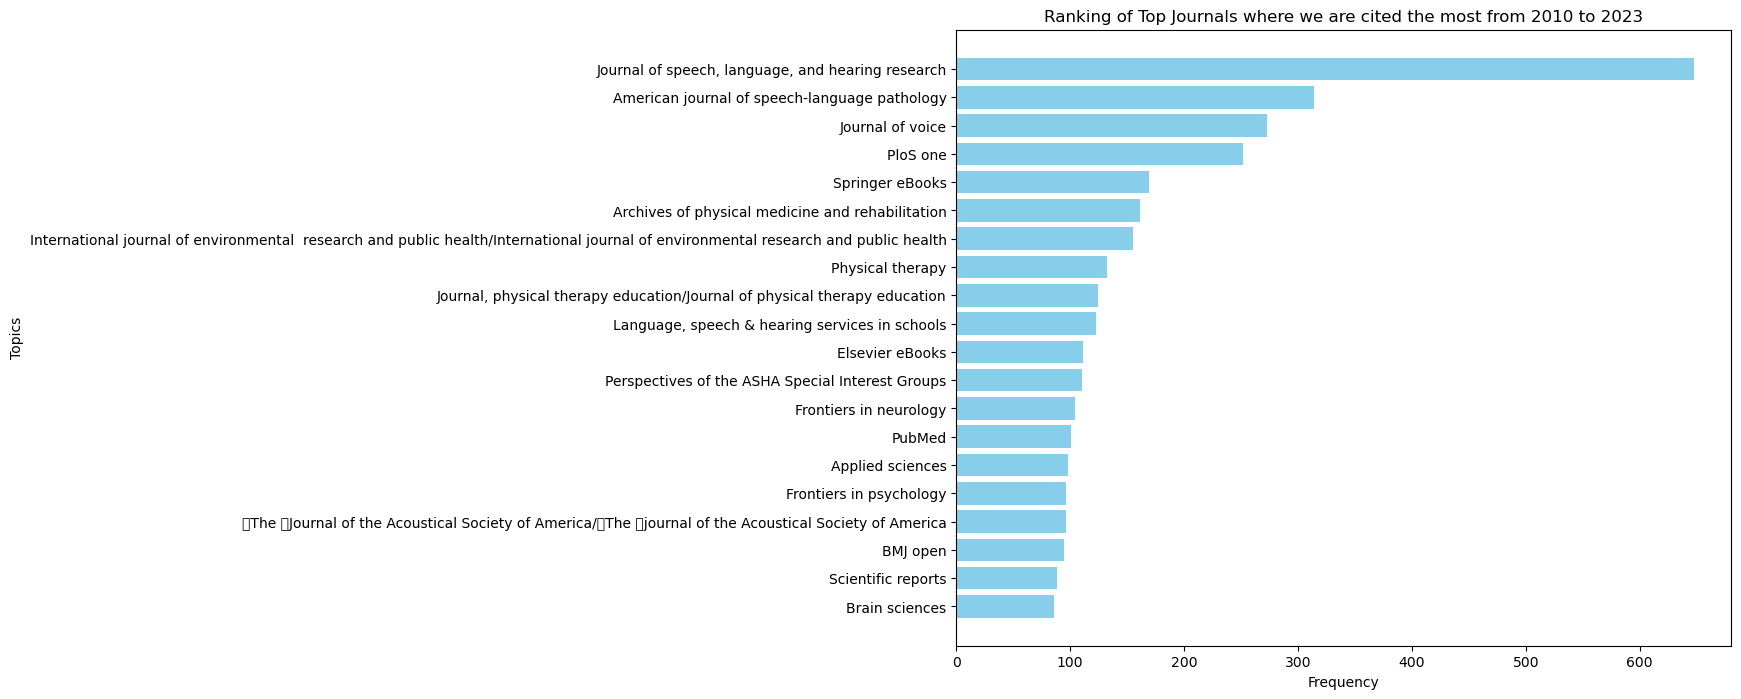

In [34]:
journal_counts = {}
journal_names_map = {}

for publication in list_data_they_cite_us:
    year = publication.get('publication_year')
    if begin <= year <= end:
        # Ensure 'primary_location' is a dictionary before accessing 'source'
        primary_location = publication.get('primary_location', {})
        source = primary_location.get('source') if isinstance(primary_location, dict) else None
        journal_id = source.get('id') if source else None
        journal_name = source.get('display_name') if source else None  # Assuming 'name' is the key for the journal name

        if journal_id and journal_name:
            # Map journal ID to name
            journal_names_map[journal_id] = journal_name

            # Count occurrences by journal ID
            if journal_id in journal_counts:
                journal_counts[journal_id] += 1
            else:
                journal_counts[journal_id] = 1

journal_counts_by_name = {journal_names_map[journal_id]: count for journal_id, count in journal_counts.items()}


plot_ranking(journal_counts_by_name, begin, end, top_n=top_n_topics, title="Top Journals where we are cited the most", save_plot=True, ppt_filename=ppt_filename)

## Some statistics about the papers that we cite

First, let's collect all of these papers. This is an extremely long process if you have cited a lot of papers. Assume at worst a second per paper.

In [35]:
referenced_ids = set()  # To store unique referenced work IDs

# Step 1: Extract referenced work IDs
for publication in data:
    referenced_works = publication.get('referenced_works', [])
    referenced_ids.update(referenced_works)  # Add new IDs to the set

# Convert set to list to keep track of indexes
referenced_ids = list(referenced_ids)

# Step 2: Query OpenAlex API for each work and store results
data_we_cite_them = []
base_url = "https://api.openalex.org/works/"

# Wrap referenced_ids with tqdm for progress tracking
for index, work_id in enumerate(tqdm(referenced_ids, total=len(referenced_ids))):
    response = requests.get(f"{base_url}{work_id}")
    if response.status_code == 200:
        work_details = response.json()
        data_we_cite_them.append(work_details)
    else:
        print(f"Failed to fetch data for work ID: {work_id}")

# Final print to indicate completion
print(f"Finished collecting data for all referenced works. Total works collected: {len(data_we_cite_them)}")

  2%|▏         | 1085/59651 [06:01<5:24:50,  3.00it/s]


SSLError: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works/https://openalex.org/W2149628477 (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1002)')))

## Number of different institutions we have cited per year

In [ ]:
# Count unique collaborating institutions per year, excluding a specific institution
collaborating_institutions_counts = count_unique_collaborating_institutions_all_years(data_we_cite_them, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_institutions_counts, begin, end, "Institutions we Cite", save_plot=True, ppt_filename=ppt_filename)

## Ranking of institutions that we have cited the most over the time span

In [ ]:
collaboration_counts = {}

for publication in data_we_cite_them:
    year = publication.get('publication_year')
    if begin <= year <= end:
        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                inst_id = institution['id']
                inst_name = institution.get('display_name', inst_id)  # Use institution ID if name is not available
                if inst_id != home_institution:  # Exclude the home institution
                    if inst_name in collaboration_counts:
                        collaboration_counts[inst_name] += 1
                    else:
                        collaboration_counts[inst_name] = 1
                            
plot_ranking(collaboration_counts, begin, end, top_n=top_n_topics, title="Top Institutions that we cite the most", save_plot=True, ppt_filename=ppt_filename)

## Number of different countries we have cited per year

In [ ]:
# Count unique collaborating countries per year, excluding a specific institution
collaborating_countries_counts = count_unique_collaborating_countries_all_years(data_we_cite_them, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_countries_counts, begin, end, "Citations of Foreign Countries by us", save_plot=True, ppt_filename=ppt_filename)

## Ranking of countries that we have cited the most over the time span

In [ ]:
collaboration_counts = {}

for publication in data_we_cite_them:
    year = publication.get('publication_year')
    if begin <= year <= end:
        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                country_code = institution.get('country_code')
                if country_code and country_code != home_country_code:  # Exclude the home country
                    if country_code in collaboration_counts:
                        collaboration_counts[country_code] += 1
                    else:
                        collaboration_counts[country_code] = 1

plot_ranking(collaboration_counts, begin, end, top_n=top_n_topics, title="Top Countries that we cite the most", save_plot=True, ppt_filename=ppt_filename)

## Number of different journals/venues we have cited per year

In [ ]:
# Count unique venues per year with the fixed function
unique_venues_counts_fixed = count_unique_venues_all_years_corrected(data_we_cite_them)

# Plotting the result with the fixed data
plot_publications_with_dynamic_sizing(unique_venues_counts_fixed, begin, end, "Unique Publication Venues we cite the most", save_plot=True, ppt_filename=ppt_filename)

## Ranking of journals/venues that we have cited the most over the time span

In [ ]:
journal_counts = {}
journal_names_map = {}

for publication in data_we_cite_them:
    year = publication.get('publication_year')
    if begin <= year <= end:
        # Ensure 'primary_location' is a dictionary before accessing 'source'
        primary_location = publication.get('primary_location', {})
        source = primary_location.get('source') if isinstance(primary_location, dict) else None
        journal_id = source.get('id') if source else None
        journal_name = source.get('display_name') if source else None  # Assuming 'name' is the key for the journal name

        if journal_id and journal_name:
            # Map journal ID to name
            journal_names_map[journal_id] = journal_name

            # Count occurrences by journal ID
            if journal_id in journal_counts:
                journal_counts[journal_id] += 1
            else:
                journal_counts[journal_id] = 1

journal_counts_by_name = {journal_names_map[journal_id]: count for journal_id, count in journal_counts.items()}


plot_ranking(journal_counts_by_name, begin, end, top_n=top_n_topics, title="Top Journals that we cited the most", save_plot=True, ppt_filename=ppt_filename)

# Using Google Scholar via SerpAPI

https://serpapi.com/playground?engine=google_scholar_author&author_id=VpTP-f8AAAAJ&hl=en

OpenAlex only indexes peer-reviewed papers, missing a lot of smaller formats (abstracts, etc). To make sure we capture all publication formats, we scrap Google Scholar and plot what we can given there is incomplete author information, topics, etc.

In order to retrieve and API key, you can follow the link above and create a free account that gives you 100 free queries/month. 

In order to get the author ID, please simply visit the scholar page for that individual (there needs to be one, therwise you are stuck with homonyms and such) and find it in the url: https://scholar.google.com/citations?user=VpTP-f8AAAAJ&hl=en&oi=ao where the id is VpTP-f8AAAAJ

In [36]:
api_key = "d024c33165acdb173c1bc46b95d988880958a85b61aec699aed4a1d8e4654fbd"

# add here author ids that you know are affiliated with your institution
authors_ids = ["VpTP-f8AAAAJ"]

In [37]:
pip install google-search-results

  Using cached google_search_results-2.4.2.tar.gz (18 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command python setup.py egg_info
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software



In [38]:
from serpapi import GoogleSearch

ImportError: cannot import name 'GoogleSearch' from 'serpapi' (C:\Users\ad1532\AppData\Local\anaconda3\Lib\site-packages\serpapi\__init__.py)

Collect the works of the authors affiliated to the group on scholar, plus those in the list.

In [ ]:
def get_authors_ids(last_author_search):
  params = {
    "engine": "google_scholar_profiles",
    "mauthors": "MGH IHP",
    "api_key": "d024c33165acdb173c1bc46b95d988880958a85b61aec699aed4a1d8e4654fbd",
    "num": 10,
    "after_author": last_author_search,
  }
  search = GoogleSearch(params)
  results = search.get_dict()
  return results


keep_going = True
initial_start = 0
last_author_search = ""
authors_list = []

while keep_going:
  results = get_authors_ids(last_author_search)
  for author in results["profiles"]:
    authors_list.append(author['author_id'])
  print(len(authors_list), "authors collected...")
  if "next_page_token" in list(results["pagination"].keys()):
    last_author_search = results["pagination"]["next_page_token"]
  else:
    keep_going = False
  if len(results["profiles"]) < 10 or len(set(authors_list)) < len(authors_list):
    keep_going = False

print(len(authors_list), "authors found")

articles = []

for author in authors_list:
  print( author)
  keep_going = True
  start = 0

  while keep_going:
    params = {
      "engine": "google_scholar_author",
      "author_id": author,
      "api_key": "d024c33165acdb173c1bc46b95d988880958a85b61aec699aed4a1d8e4654fbd",
      "num": 100,
      "start": start,
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    try:
      articles.extend(results["articles"])
      print(len(articles))
      keep_going = (len(results["articles"]) == 100)
      start += 100
    except KeyError:
      break

In [ ]:
# The filename where you want to save the JSON data
filename = f'{folder_plots}' + home_institution.split('/')[-1] + "_scholar" + '.json'

# Saving the list of dictionaries as a JSON file
with open(filename, 'w') as file:
    json.dump(pages, file, indent=4)

print(f'Data saved to {filename}')

In [ ]:
articles[0]

Number of publications per year

In [ ]:
# Sample data list
publications = articles

# Function to convert publication list into a dictionary of {year: count}
def prepare_publications_data(publications):
    count = 0
    publications_by_year = {}
    for pub in publications:
      if pub['year'] != '':
        year = int(pub['year'])  # Convert year to integer
      else:
        count += 1
      if year in publications_by_year:
        publications_by_year[year] += 1
      else:
        publications_by_year[year] = 1
    print(count, "publications with no year were dropped")
    return publications_by_year

# Prepare data
publications_data = prepare_publications_data(publications)

# Example usage of the function
plot_publications_with_dynamic_sizing(publications_data, begin, end, title="Google Scholar", save_plot=True, ppt_filename=ppt_filename)

Number of citations attributed to that year's publication

In [ ]:
# Function to convert publication list into a dictionary of {year: total citations}
def prepare_citations_data(publications):
    citations_by_year = {}
    for pub in publications:
        if 'year' in pub and pub['year']:  # Check if year is available and not empty
            year = int(pub['year'])
            if 'cited_by' in pub and 'value' in pub['cited_by']:
                citation_count = pub['cited_by']['value']
            else:
                citation_count = 0
            if year in citations_by_year:
                if citation_count is not None:
                    citations_by_year[year] += citation_count
            else:
                if citation_count is not None:
                    citations_by_year[year] = citation_count
    return citations_by_year

# Prepare data
citations_data = prepare_citations_data(publications)

# Example usage of the function
plot_publications_with_dynamic_sizing(citations_data, begin, end, title="Total Citations per Year", save_plot=True, ppt_filename=ppt_filename)

Number of citations obtained by year

In [ ]:
# Function to aggregate citations per year from multiple publications
def aggregate_citations(results):
    citations_by_year = {}
    if 'cited_by' in results and 'graph' in results['cited_by']:
        for data_point in results['cited_by']['graph']:
            year = data_point['year']
            citations = data_point['citations']
            if year in citations_by_year:
                citations_by_year[year] += citations
            else:
                citations_by_year[year] = citations
    return citations_by_year

# Aggregate data
citations_data = aggregate_citations(results)

# Example usage of the function
plot_publications_with_dynamic_sizing(citations_data, begin, end, title="Total Citations per Year", save_plot=True, ppt_filename=ppt_filename)